In [1]:
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py

mpl.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 17

from tqdne.conf import Config
config = Config()
dataset_path = "/store/sdsc/sd28/wforms_GAN_input_v20220805.h5"
dataset_path

'/store/sdsc/sd28/wforms_GAN_input_v20220805.h5'

In [2]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

with h5py.File(dataset_path, 'r', locking=False) as f:
    print("File attributes:")
    print_attrs(dataset_path, f)
    f.visititems(print_attrs)

File attributes:
/store/sdsc/sd28/wforms_GAN_input_v20220805.h5
    HP_filter_freq_lo: [1.]
    HP_filter_name: Butterworth
    HP_filter_order: [2.]
    HP_filter_type: causal
    component_order: NEZ
    creation_date: 06-Aug-2022 00:14:53
    h5Dir: /scratch/memeier/data/general/japan/bosai22/dl20220725/arx20220730/proj/wfGAN/h5/new
    hypo_dist_max: [180.]
    hypo_dist_min: [0.]
    magnitude_max: [10.]
    magnitude_min: [4.5]
    matDir: /scratch/memeier/data/general/japan/bosai22/dl20220725/arx20220730/proj/wfGAN/out
    stationList: dat/site/sitepub_all_en.txt
hypocentral_distance
hypocentre_depth
hypocentre_latitude
hypocentre_longitude
is_shallow_crustal
log10snr
magnitude
time_vector
vs30
waveforms


# Raw Dataset

In [3]:
# Check for NaNs or inf values
with h5py.File(dataset_path, "r") as f:
    for key in f.keys():
        print(key, np.isnan(f[key][...]).any(), np.isinf(f[key][...]).any())

hypocentral_distance False False
hypocentre_depth False False
hypocentre_latitude False False
hypocentre_longitude False False
is_shallow_crustal False False
log10snr False True
magnitude False False
time_vector False False
vs30 False False
waveforms True False


In [4]:
# Check the range of each dataset
with h5py.File(dataset_path, "r") as f:
    for key in f.keys():
        print(key, f[key][...].min(), f[key][...].max())

hypocentral_distance 3.977979103656216 179.9995778949701
hypocentre_depth 0.0 178.31
hypocentre_latitude 23.38 46.88
hypocentre_longitude 122.18 147.81
is_shallow_crustal 0.0 1.0
log10snr -1.185691777479842 inf
magnitude 4.5 9.083505377573305
time_vector -5.0 50.0
vs30 -1.0 2100.000000000001
waveforms nan nan


In [5]:
# Check the shape of each dataset
with h5py.File(dataset_path, "r") as f:
    for key in f.keys():
        print(key, f[key][...].shape)

hypocentral_distance (1, 212598)
hypocentre_depth (1, 212598)
hypocentre_latitude (1, 212598)
hypocentre_longitude (1, 212598)
is_shallow_crustal (1, 212598)
log10snr (1, 212598)
magnitude (1, 212598)
time_vector (5501,)
vs30 (1, 212598)
waveforms (3, 5501, 212598)


# Processed dataset

- log10snr is removed;
- NaN in waveforms are replaced with 0, as they're often placed at the beginning of the signal (see envelope.ipynb); 
- vs30<=0 are removed


In [2]:
train_path = Path('../datasets/GM0-dataset-split/') / f'{config.data_train}'
with h5py.File(train_path, "r") as f:
    for key in f.keys():
        print(key, f[key][...].shape)

features (177633, 4)


waveforms (177633, 3, 5501)


In [3]:
test_path = Path('../datasets/GM0-dataset-split/') / f'{config.data_test}'
with h5py.File(test_path, "r") as f:
    for key in f.keys():
        print(key, f[key][...].shape)

features (19737, 4)
waveforms (19737, 3, 5501)


In [4]:
from tqdne.dataset import RepresentationDataset
from tqdne.representations import Signal

train_dataset = RepresentationDataset(train_path, Signal())
test_dataset = RepresentationDataset(test_path, Signal())

In [5]:
#combine train and test datasets
waveforms = np.concatenate([train_dataset.waveforms, test_dataset.waveforms])
features = np.concatenate([train_dataset.features, test_dataset.features])
waveforms.shape, features.shape 

((197370, 3, 5501), (197370, 4))

## Check what is the range of each feature

In [11]:
for i in range(features.shape[-1]):
    print(f'Feature {config.features_keys[i]} --  min: {np.nanmin(features[:, i])}, max: {np.ma.masked_invalid(features[:, i]).max()}, max_inf: {np.max(features[:, i])}, min_inf: {np.min(features[:, i])}')

Feature hypocentral_distance --  min: 3.9779791831970215, max: 179.99957275390625, max_inf: 179.99957275390625, min_inf: 3.9779791831970215
Feature is_shallow_crustal --  min: 0.0, max: 1.0, max_inf: 1.0, min_inf: 0.0
Feature magnitude --  min: 4.5, max: 9.083505630493164, max_inf: 9.083505630493164, min_inf: 4.5
Feature vs30 --  min: 76.27909851074219, max: 2100.0, max_inf: 2100.0, min_inf: 76.27909851074219


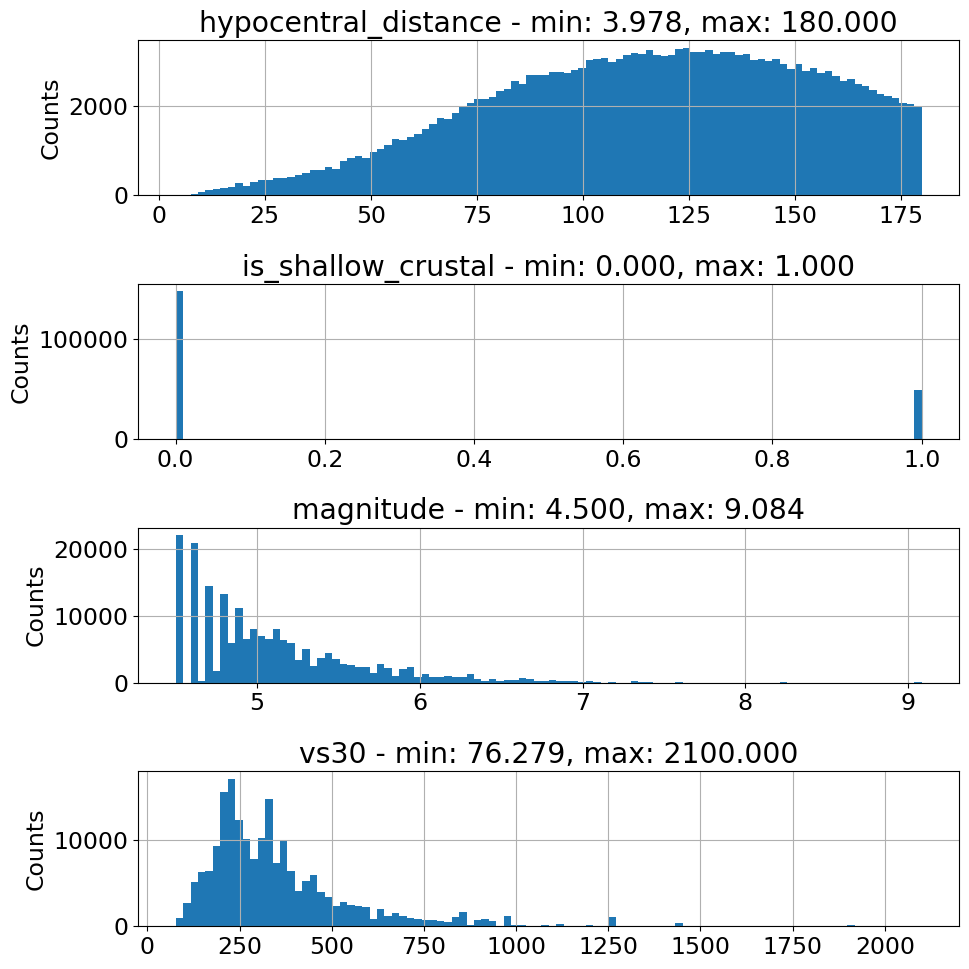

In [11]:
# Visualize histogram for each feature
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for i in range(features.shape[-1]):
    axs[i].hist(features[:, i], bins=100)
    axs[i].set_title(f'{config.features_keys[i]} - min: {np.min(features[:, i]):.3f}, max: {np.max(features[:, i]):.3f}')
    axs[i].set_ylabel('Counts')
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [17]:
mpl.rcParams['font.size'] = 20

/tmp/ipykernel_12090/3413434734.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


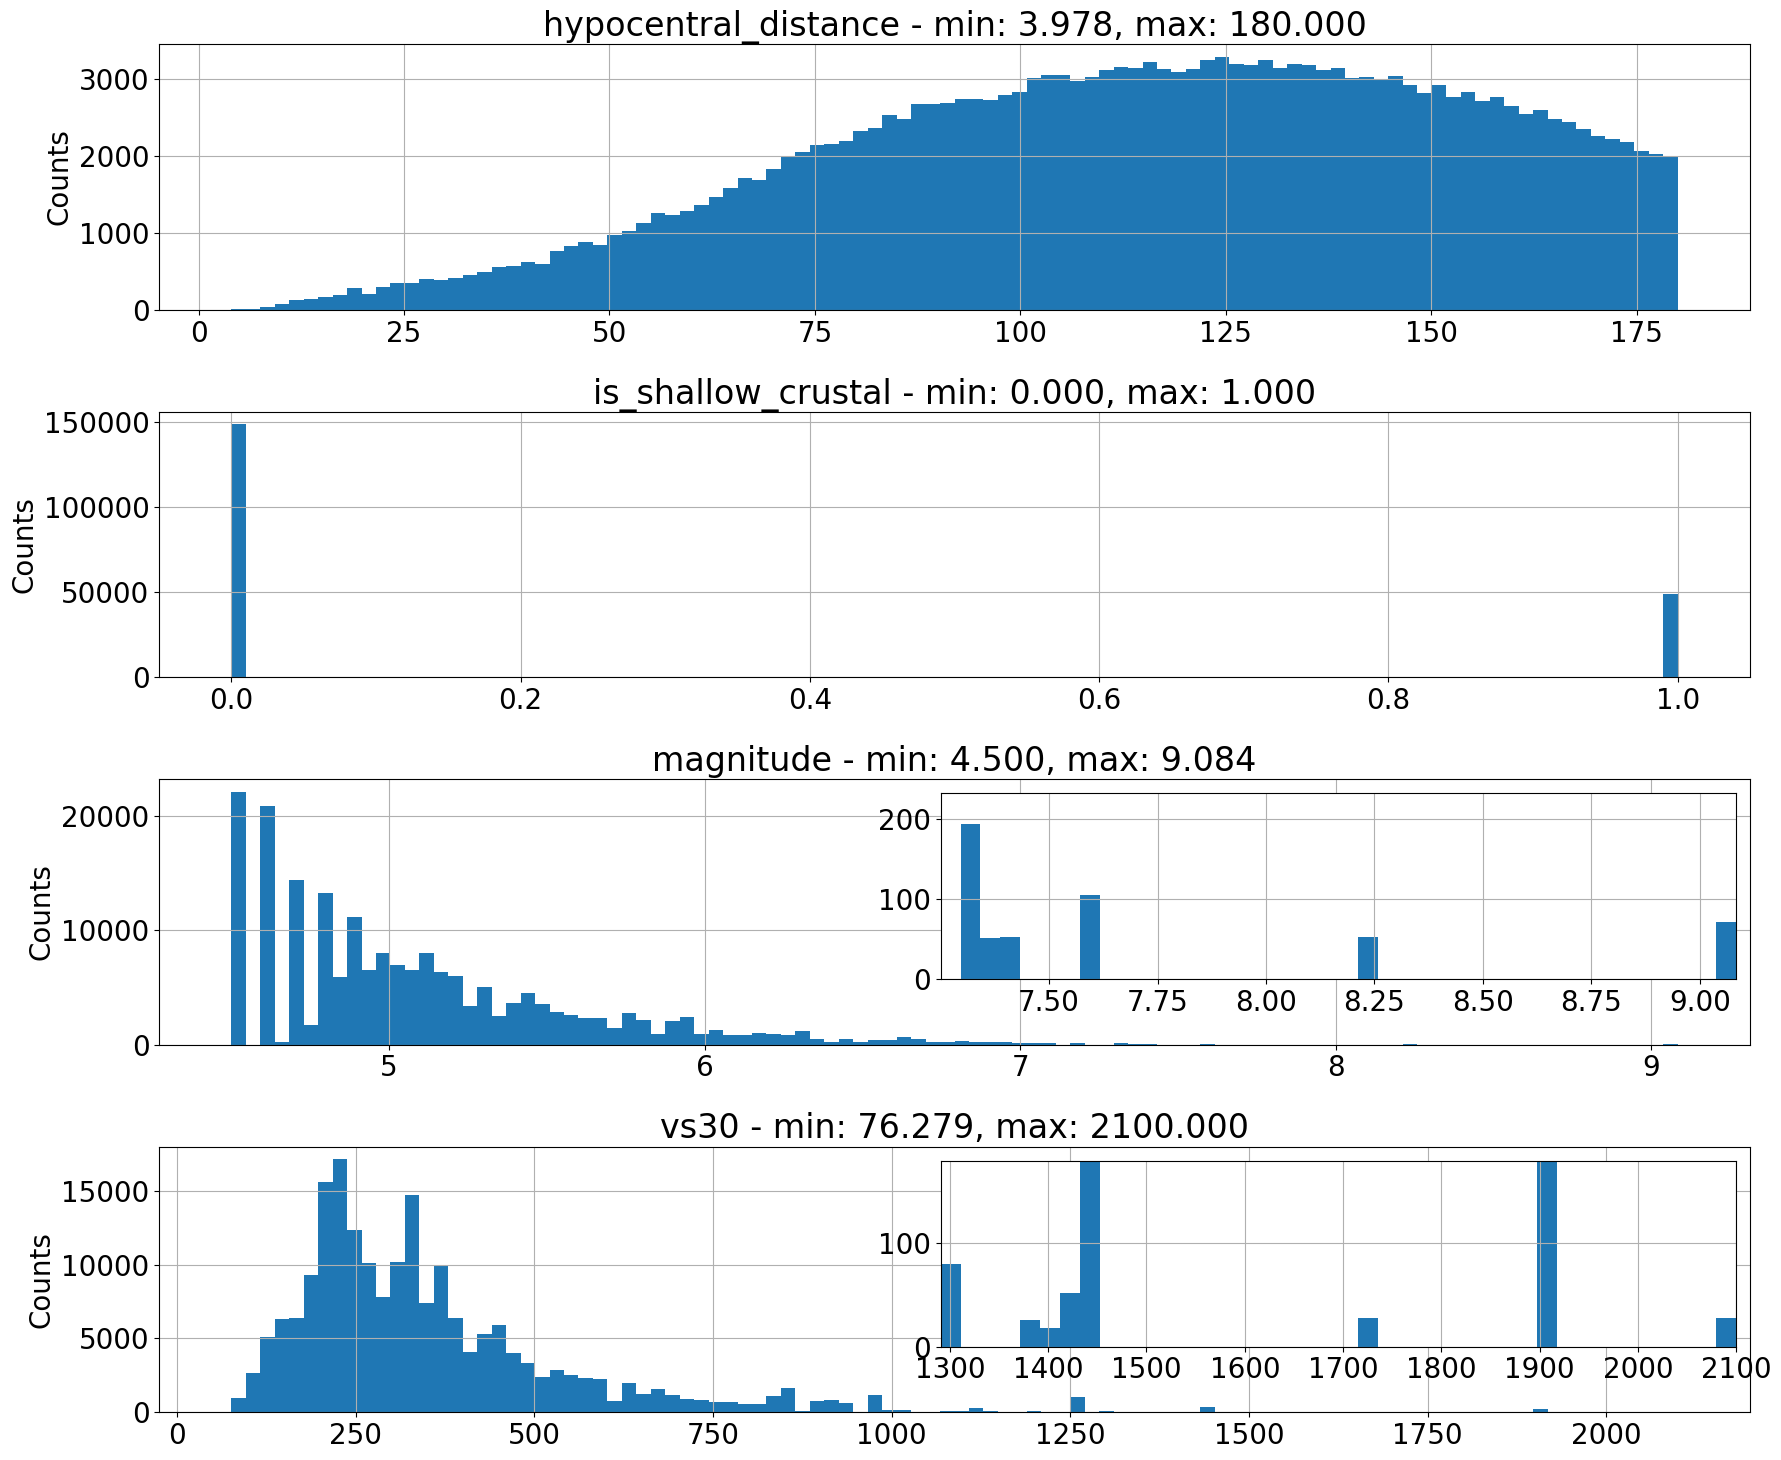

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Visualize histogram for each feature
fig, axs = plt.subplots(4, 1, figsize=(18, 15))
for i in range(features.shape[-1]):
    axs[i].hist(features[:, i], bins=100)
    axs[i].set_title(f'{config.features_keys[i]} - min: {np.min(features[:, i]):.3f}, max: {np.max(features[:, i]):.3f}')
    axs[i].set_ylabel('Counts')
    axs[i].grid(True)

    if i >= 2:
        # Add a zoomed-in subplot on the second half of the x-axis
        axins = inset_axes(axs[i], width="50%", height="70%", loc='upper right')
        axins.hist(features[:, i], bins=100)
        xmin, xmax = np.min(features[:, i]), np.max(features[:, i])
        # Zoom in on the last 3/4 of the x-axis
        axins.set_xlim(xmin + 0.6 * (xmax - xmin), xmax)
        # Set the y-axis limit to focus on low y values
        axins.set_ylim(0, np.max(axins.get_ylim()) * 0.01)
        axins.grid(True)

plt.tight_layout()
plt.show()

## Check if there are any `nan` or `inf` values

In [13]:
np.any(np.isnan(waveforms)), np.any(np.isnan(features)), np.any(np.isinf(waveforms)), np.any(np.isinf(features))

(False, False, False, False)

In [14]:
print("Number of shallow crustal envents: ", int(np.sum(features[:, 1])))

Number of shallow crustal envents:  49036


## Plot of a waveform

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


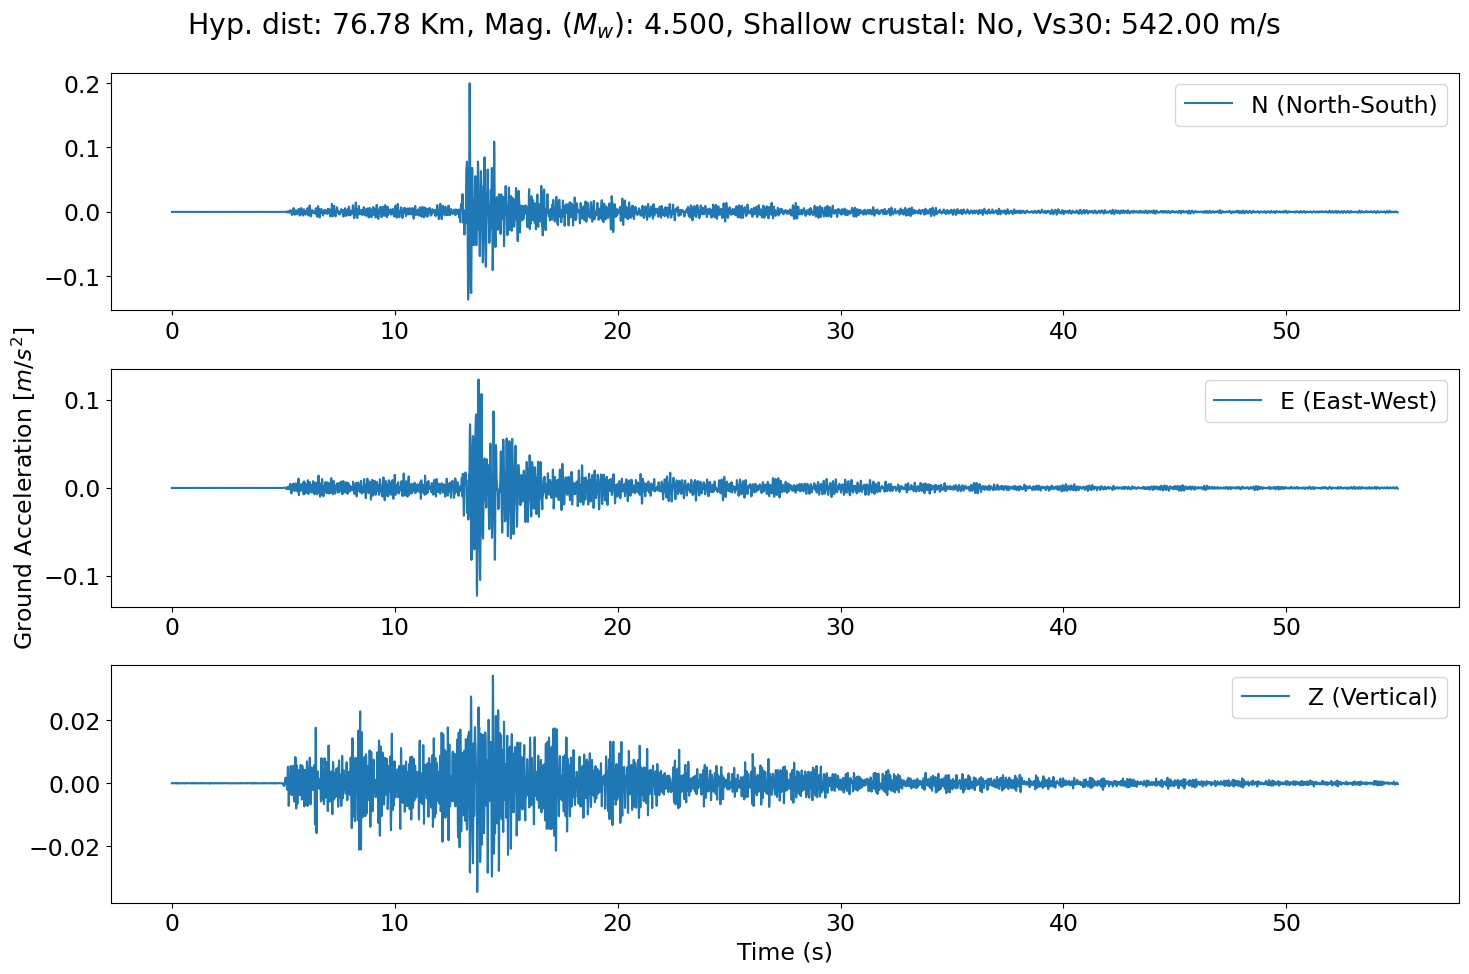

In [12]:
sample = train_dataset[5645]

# Plot the three components of the waveform
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
ch_mapping = {0: 'N (North-South)', 1: 'E (East-West)', 2: 'Z (Vertical)'}
time_ax = np.arange(0, sample['waveform'].shape[-1]) / config.fs
for ch in range(config.num_channels):
    axs[ch].plot(time_ax, sample['waveform'][ch], label=ch_mapping[ch])
    axs[ch].legend()

from tqdne.utils import get_cond_params_str
title = get_cond_params_str(sample['cond'])
# set title, and axis labels on the outer plot
fig.suptitle(title)
axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel('Ground Acceleration [$m/s^2$]')

plt.tight_layout()
plt.show()

## Visualize the effect of `hypocentral_distance` on waveforms 

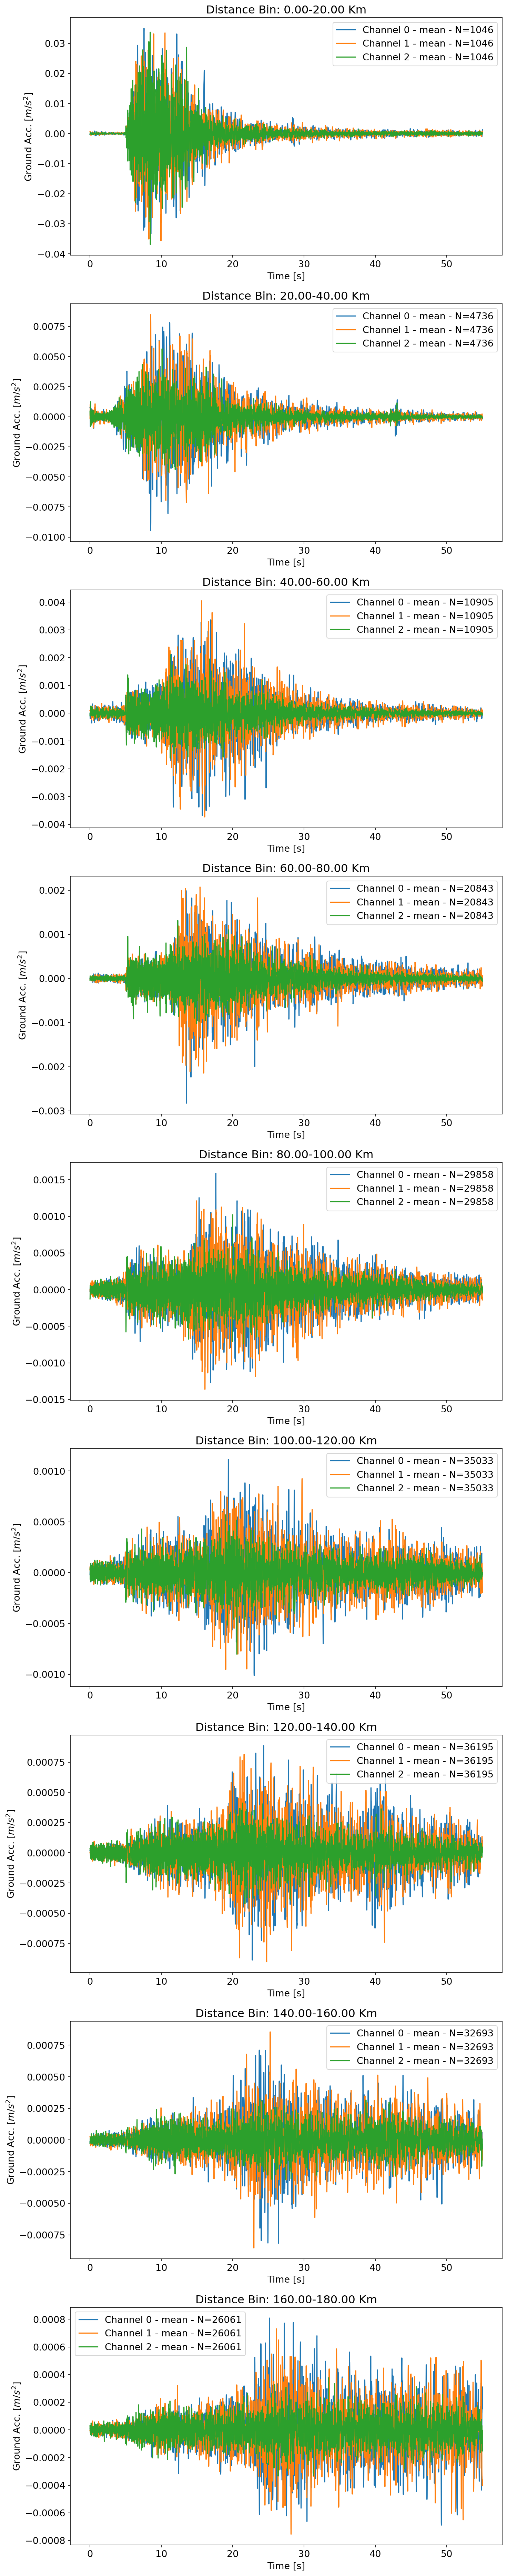

In [16]:
# define distance bins
dist_bins = np.linspace(config.conditional_params_range["hypocentral_distance"][0], config.conditional_params_range["hypocentral_distance"][1], 10)

# divide samples in dist_bins
dist_bins_samples = []
for i in range(len(dist_bins) - 1):
    mask = (features[:, 0] >= dist_bins[i]) & (features[:, 0] < dist_bins[i + 1])
    dist_bins_samples.append(waveforms[mask])

# plot the mean of each bin
fig, ax = plt.subplots(len(dist_bins) - 1, 1, figsize=(10, 5*len(dist_bins)))
time_ax = np.arange(0, waveforms.shape[-1]) / config.fs
for i in range(len(dist_bins_samples)):
    mean_signals = np.mean(dist_bins_samples[i], axis=0)
    for j in range(mean_signals.shape[0]):
        ax[i].plot(time_ax, mean_signals[j], label=f"Channel {j} - mean - N={dist_bins_samples[i].shape[0]}")
    ax[i].legend()
    ax[i].set_title(f"Distance Bin: {dist_bins[i]:.2f}-{dist_bins[i+1]:.2f} Km")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Ground Acc. [$m/s^2$]")
    fig.tight_layout()

Check if that's the case also by fixing the magnitude

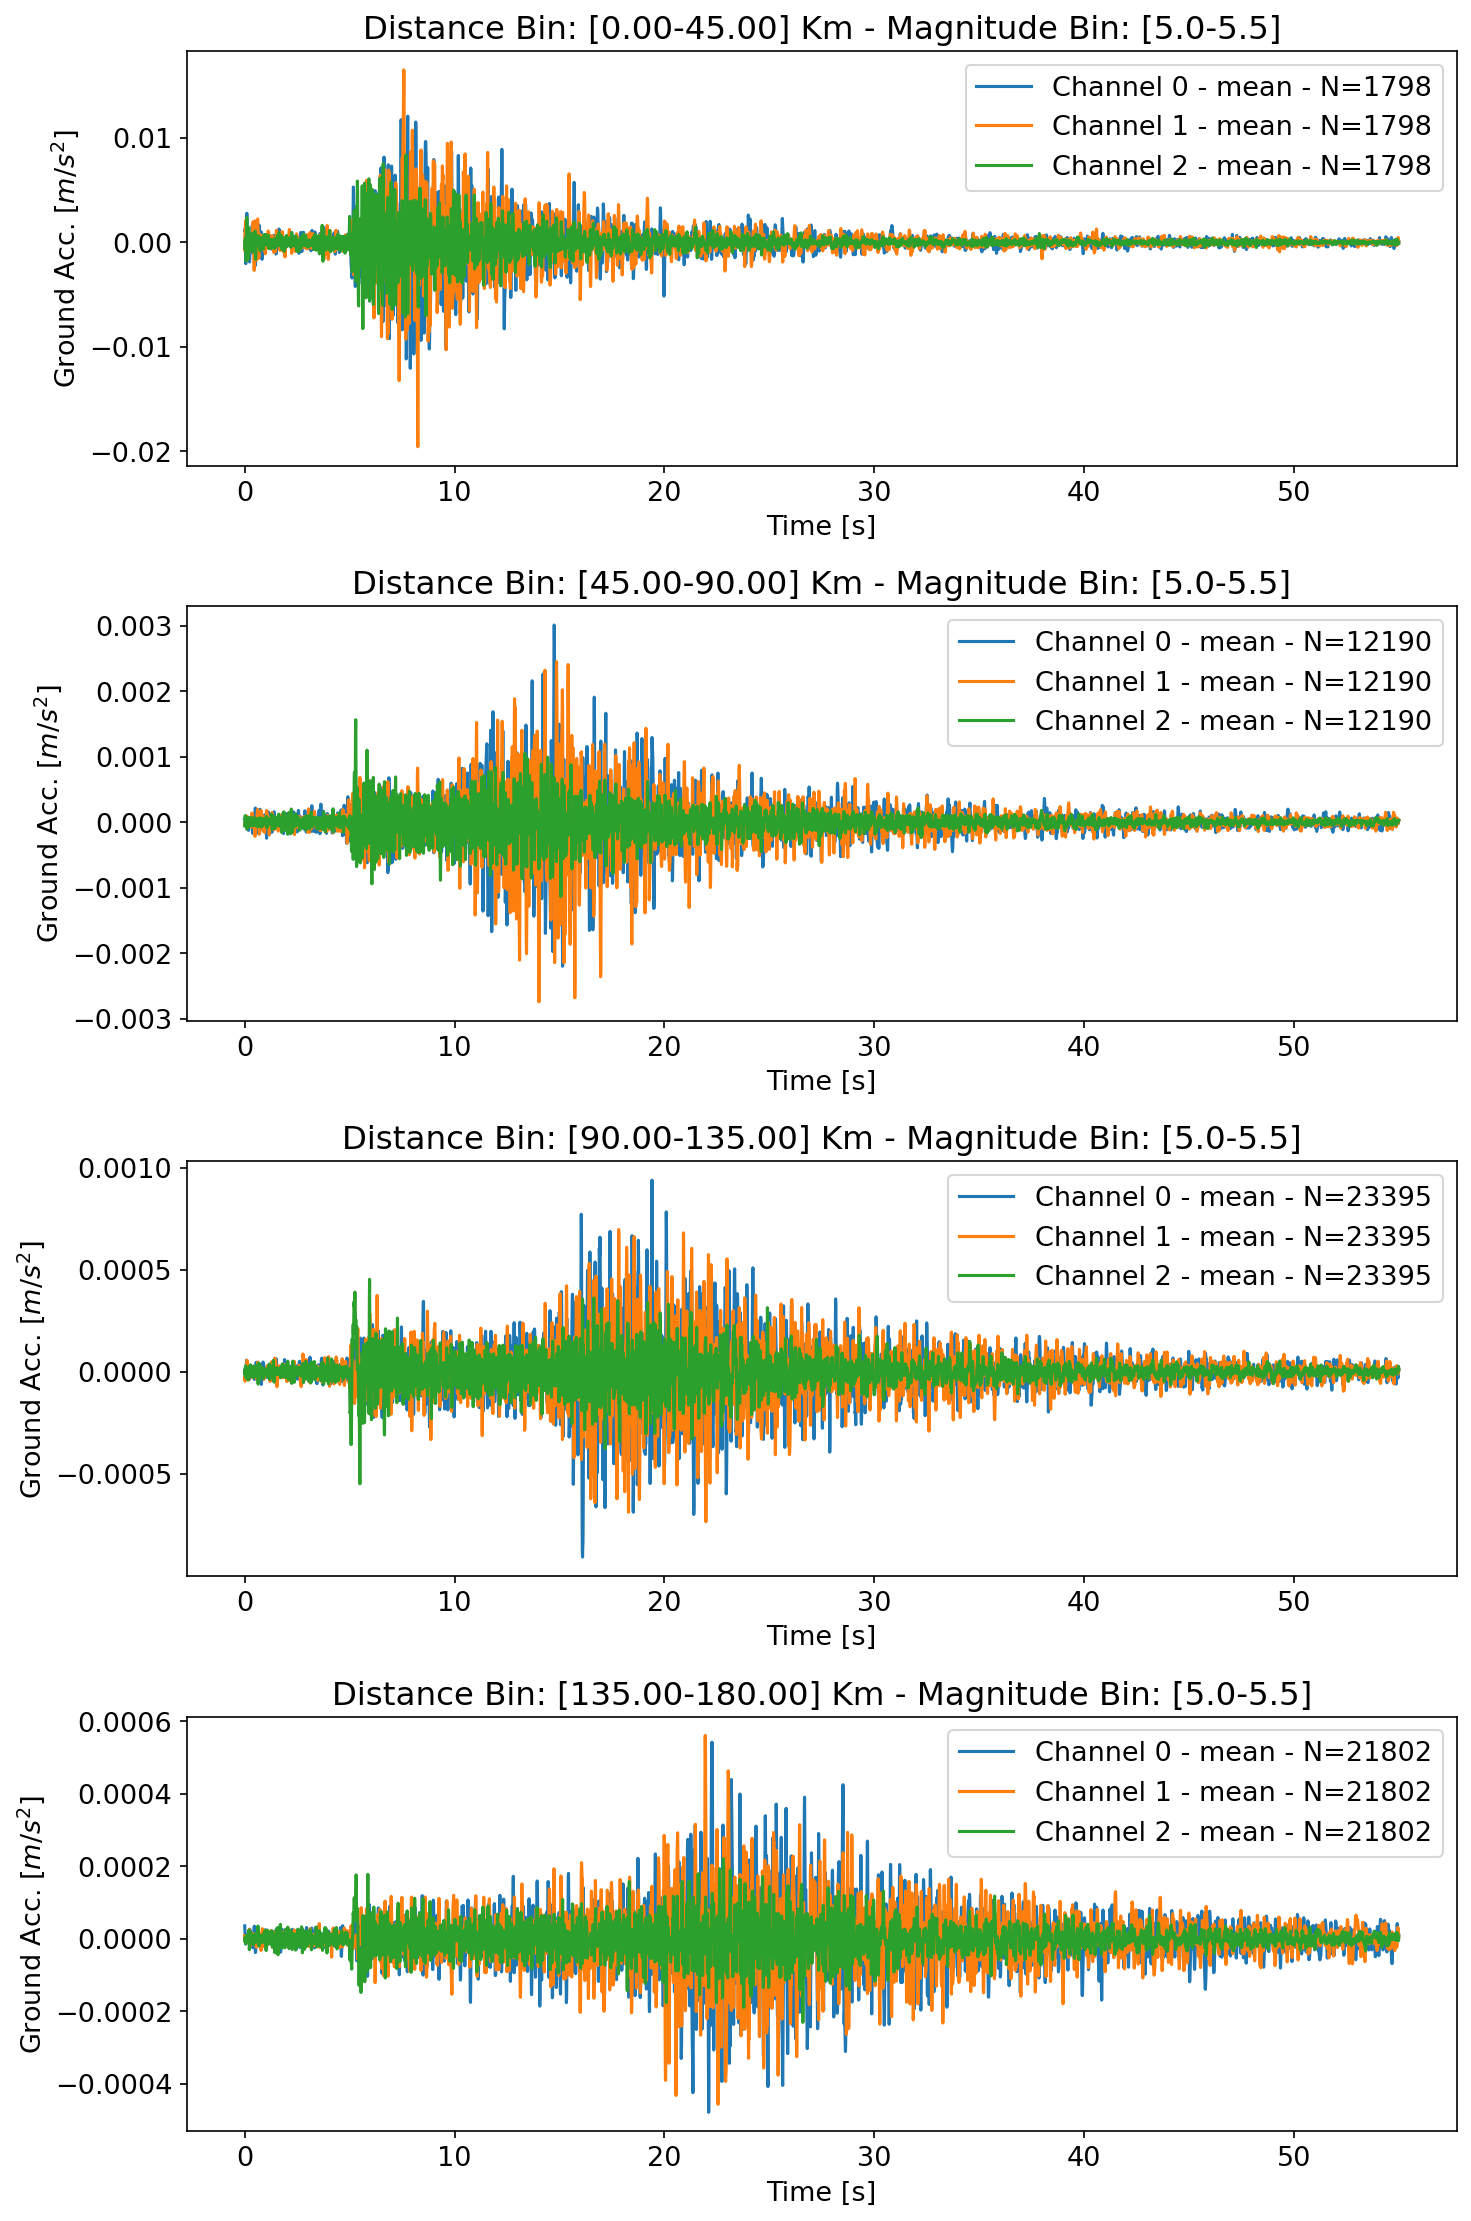

In [17]:
# define distance bins
dist_bins = np.linspace(config.conditional_params_range["hypocentral_distance"][0], config.conditional_params_range["hypocentral_distance"][1], 5)

# Fix the magnitude range
mag_bin = [5., 5.5]
mag_mask = (features[:, 2] >= mag_bin[0]) & (features[:, 2] < mag_bin[1])

# divide samples in dist_bins
dist_bins_samples = []
for i in range(len(dist_bins) - 1):
    mask = (features[:, 0] >= dist_bins[i]) & (features[:, 0] < dist_bins[i + 1]) & mag_mask
    dist_bins_samples.append(waveforms[mask])

# plot the mean of each bin
fig, ax = plt.subplots(len(dist_bins) - 1, 1, figsize=(10, 3*len(dist_bins)))
time_ax = np.arange(0, waveforms.shape[-1]) / config.fs
for i in range(len(dist_bins_samples)):
    mean_signals = np.mean(dist_bins_samples[i], axis=0)
    for j in range(mean_signals.shape[0]):
        ax[i].plot(time_ax, mean_signals[j], label=f"Channel {j} - mean - N={dist_bins_samples[i].shape[0]}")
    ax[i].legend()
    ax[i].set_title(f"Distance Bin: [{dist_bins[i]:.2f}-{dist_bins[i+1]:.2f}] Km - Magnitude Bin: [{mag_bin[0]}-{mag_bin[1]}]")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Ground Acc. [$m/s^2$]")
    fig.tight_layout()

## Check the diversity of the dataset

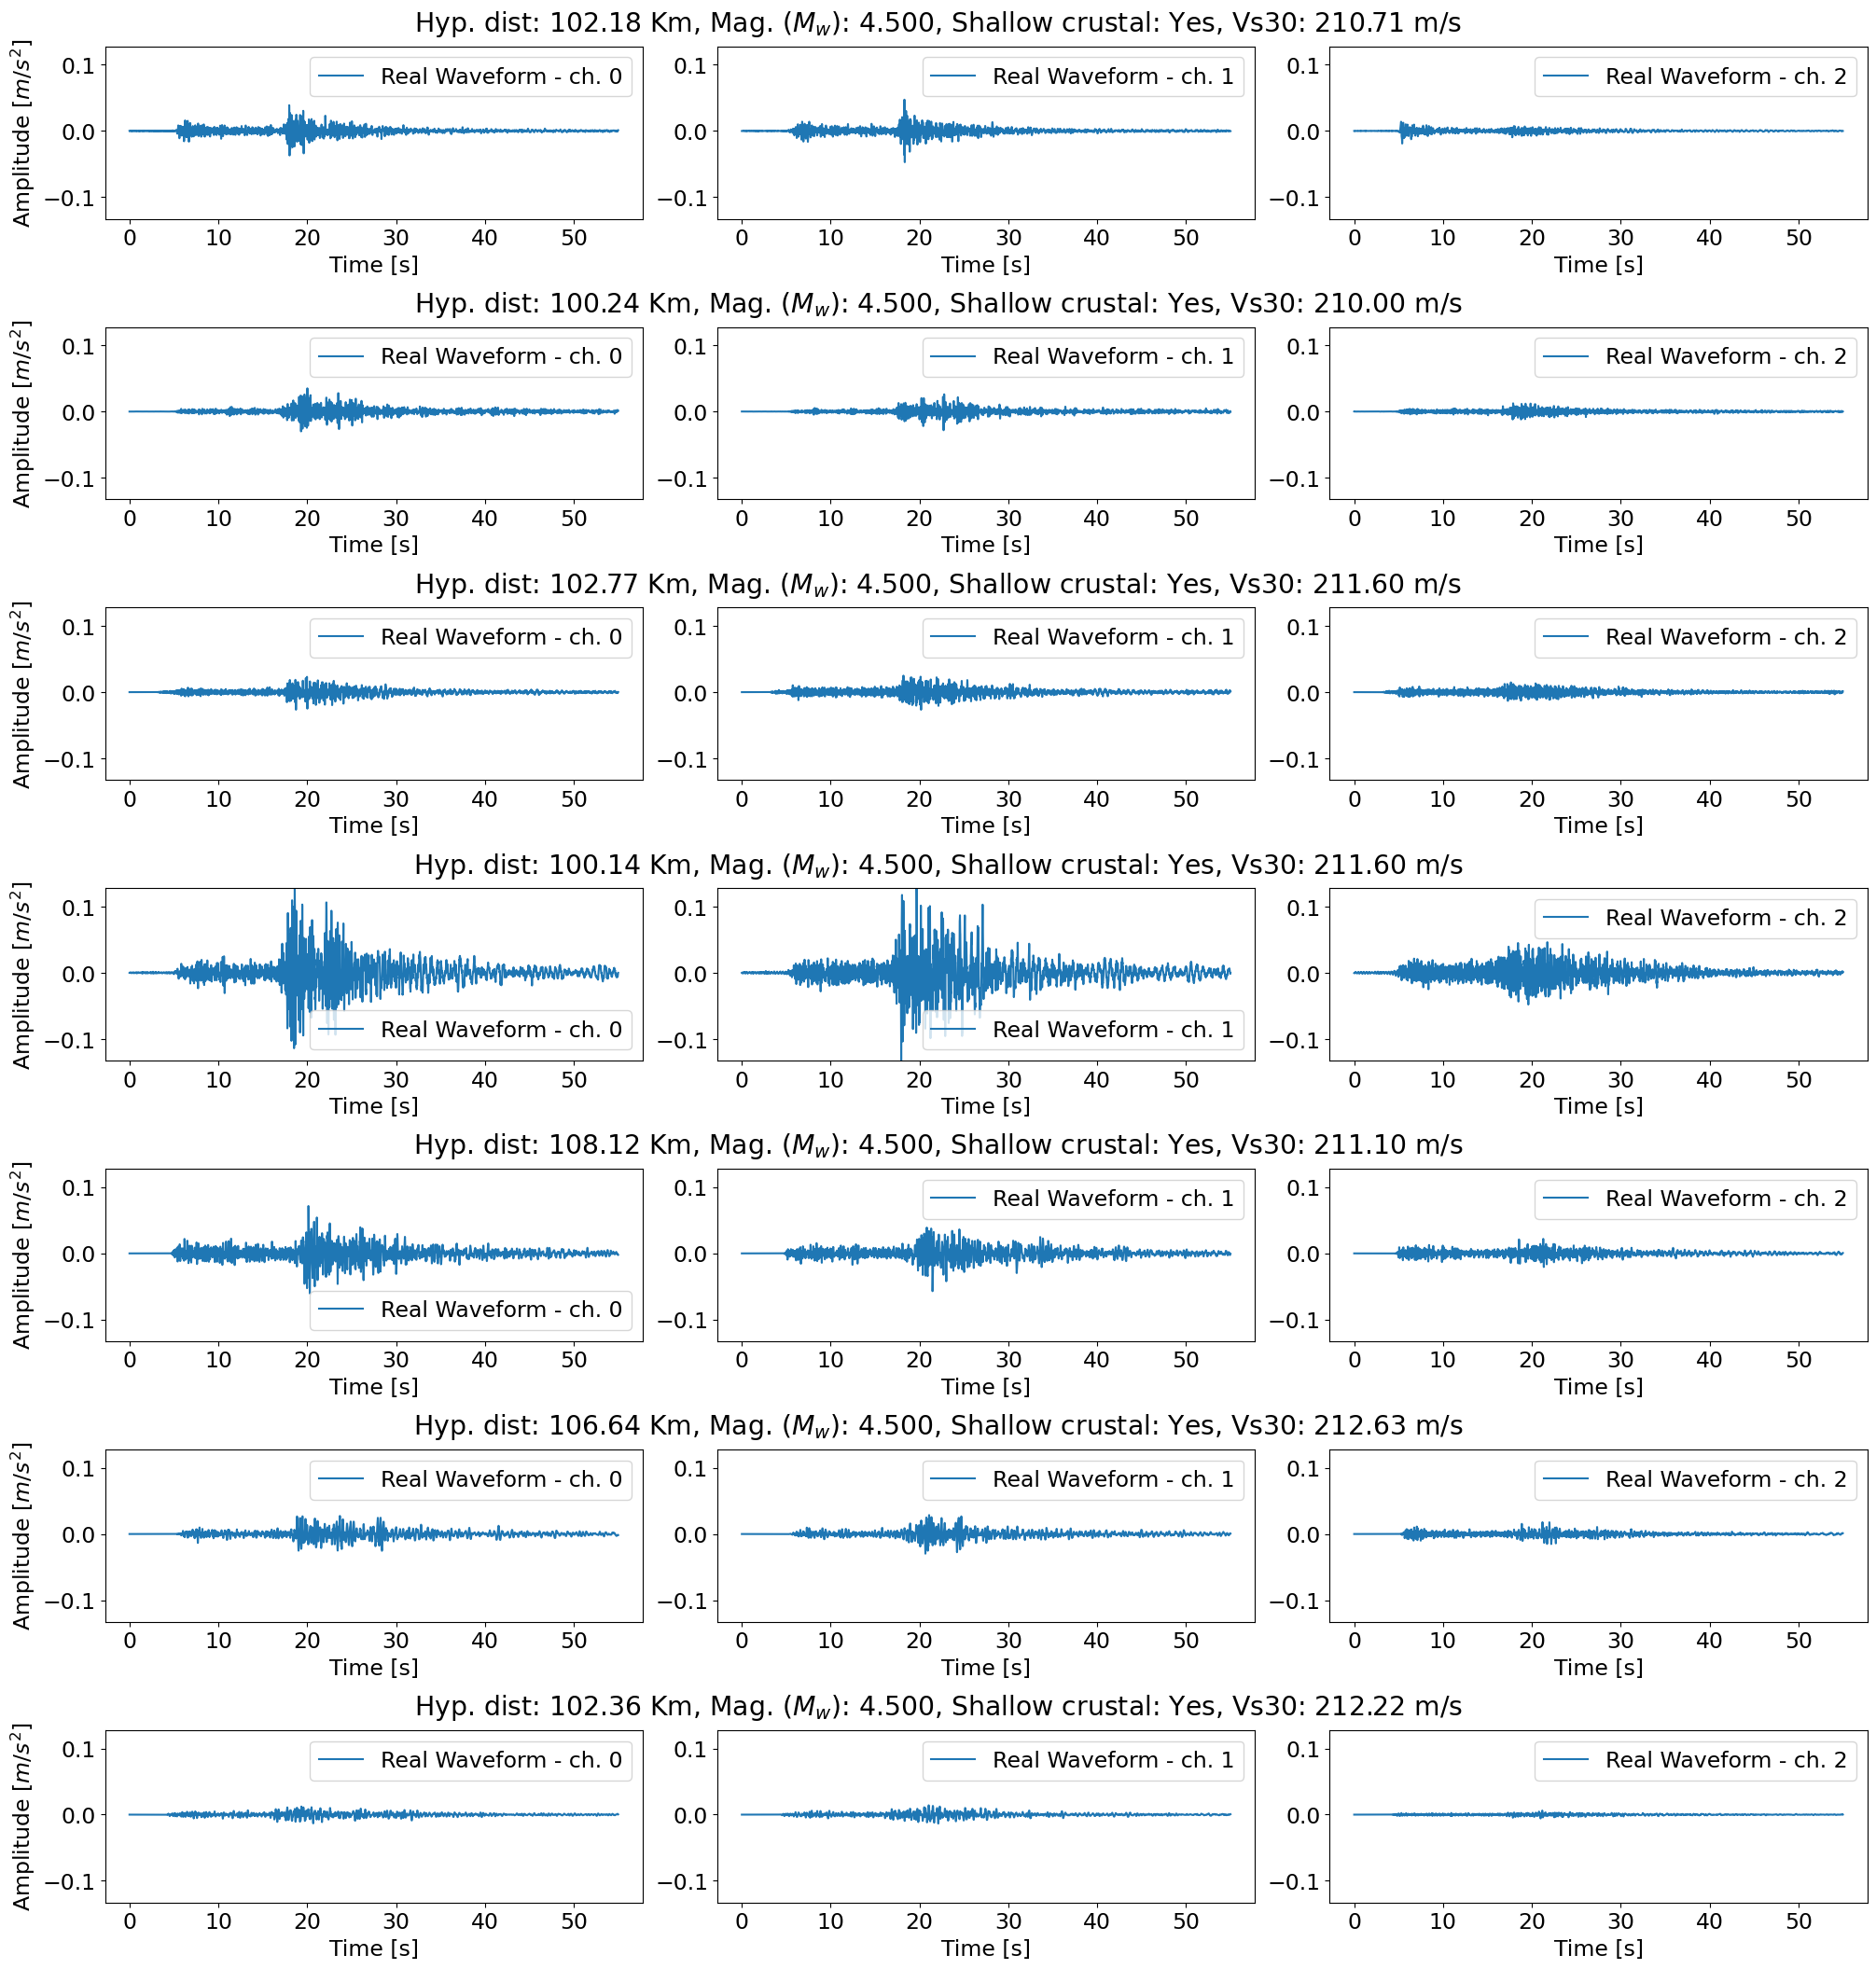

In [14]:
from tqdne.utils import get_cond_params_str
n_samples = 7

data_bin = train_dataset.get_data_by_bin(magnitude_bin=(4.5, 4.6), distance_bin=(100, 110), is_shallow_crustal=True)
bins_idxs_vs30 = (data_bin['cond'][:, -1] >= 210) & (data_bin['cond'][:, -1] < 215)

params_bin = data_bin['cond'][bins_idxs_vs30][:n_samples]
waveforms_bin = data_bin['waveform'][bins_idxs_vs30][:n_samples]

n_channels = waveforms_bin.shape[1]

time_ax = np.arange(0, waveforms_bin.shape[-1]) / config.fs

# fix ylim based on the extremal values of the waveforms
y_range = (
    min(waveforms_bin.flatten()),
    max(waveforms_bin.flatten())
)

fig = plt.figure(constrained_layout=True, figsize=(20, 3*n_samples))

# Create a subfigure for each row
subfigs = fig.subfigures(n_samples, 1)

for i in range(n_samples):
    # Add a title for each row
    subfigs[i].suptitle(get_cond_params_str(params_bin[i]))

    # Create the subplots within the subfigure
    axs = subfigs[i].subplots(1, n_channels)
    for ch in range(n_channels):
        axs[ch].plot(time_ax, waveforms_bin[i, ch], label=f'Real Waveform - ch. {ch}')
        axs[ch].set_ylim(y_range)
        axs[ch].set_xlabel('Time [s]')
        if ch == 0:
            axs[ch].set_ylabel('Amplitude [$m/s^2$]')
        axs[ch].legend()

plt.show()

## Check the median spectrum in the fequency domain of all the waveforms

done computing ffts


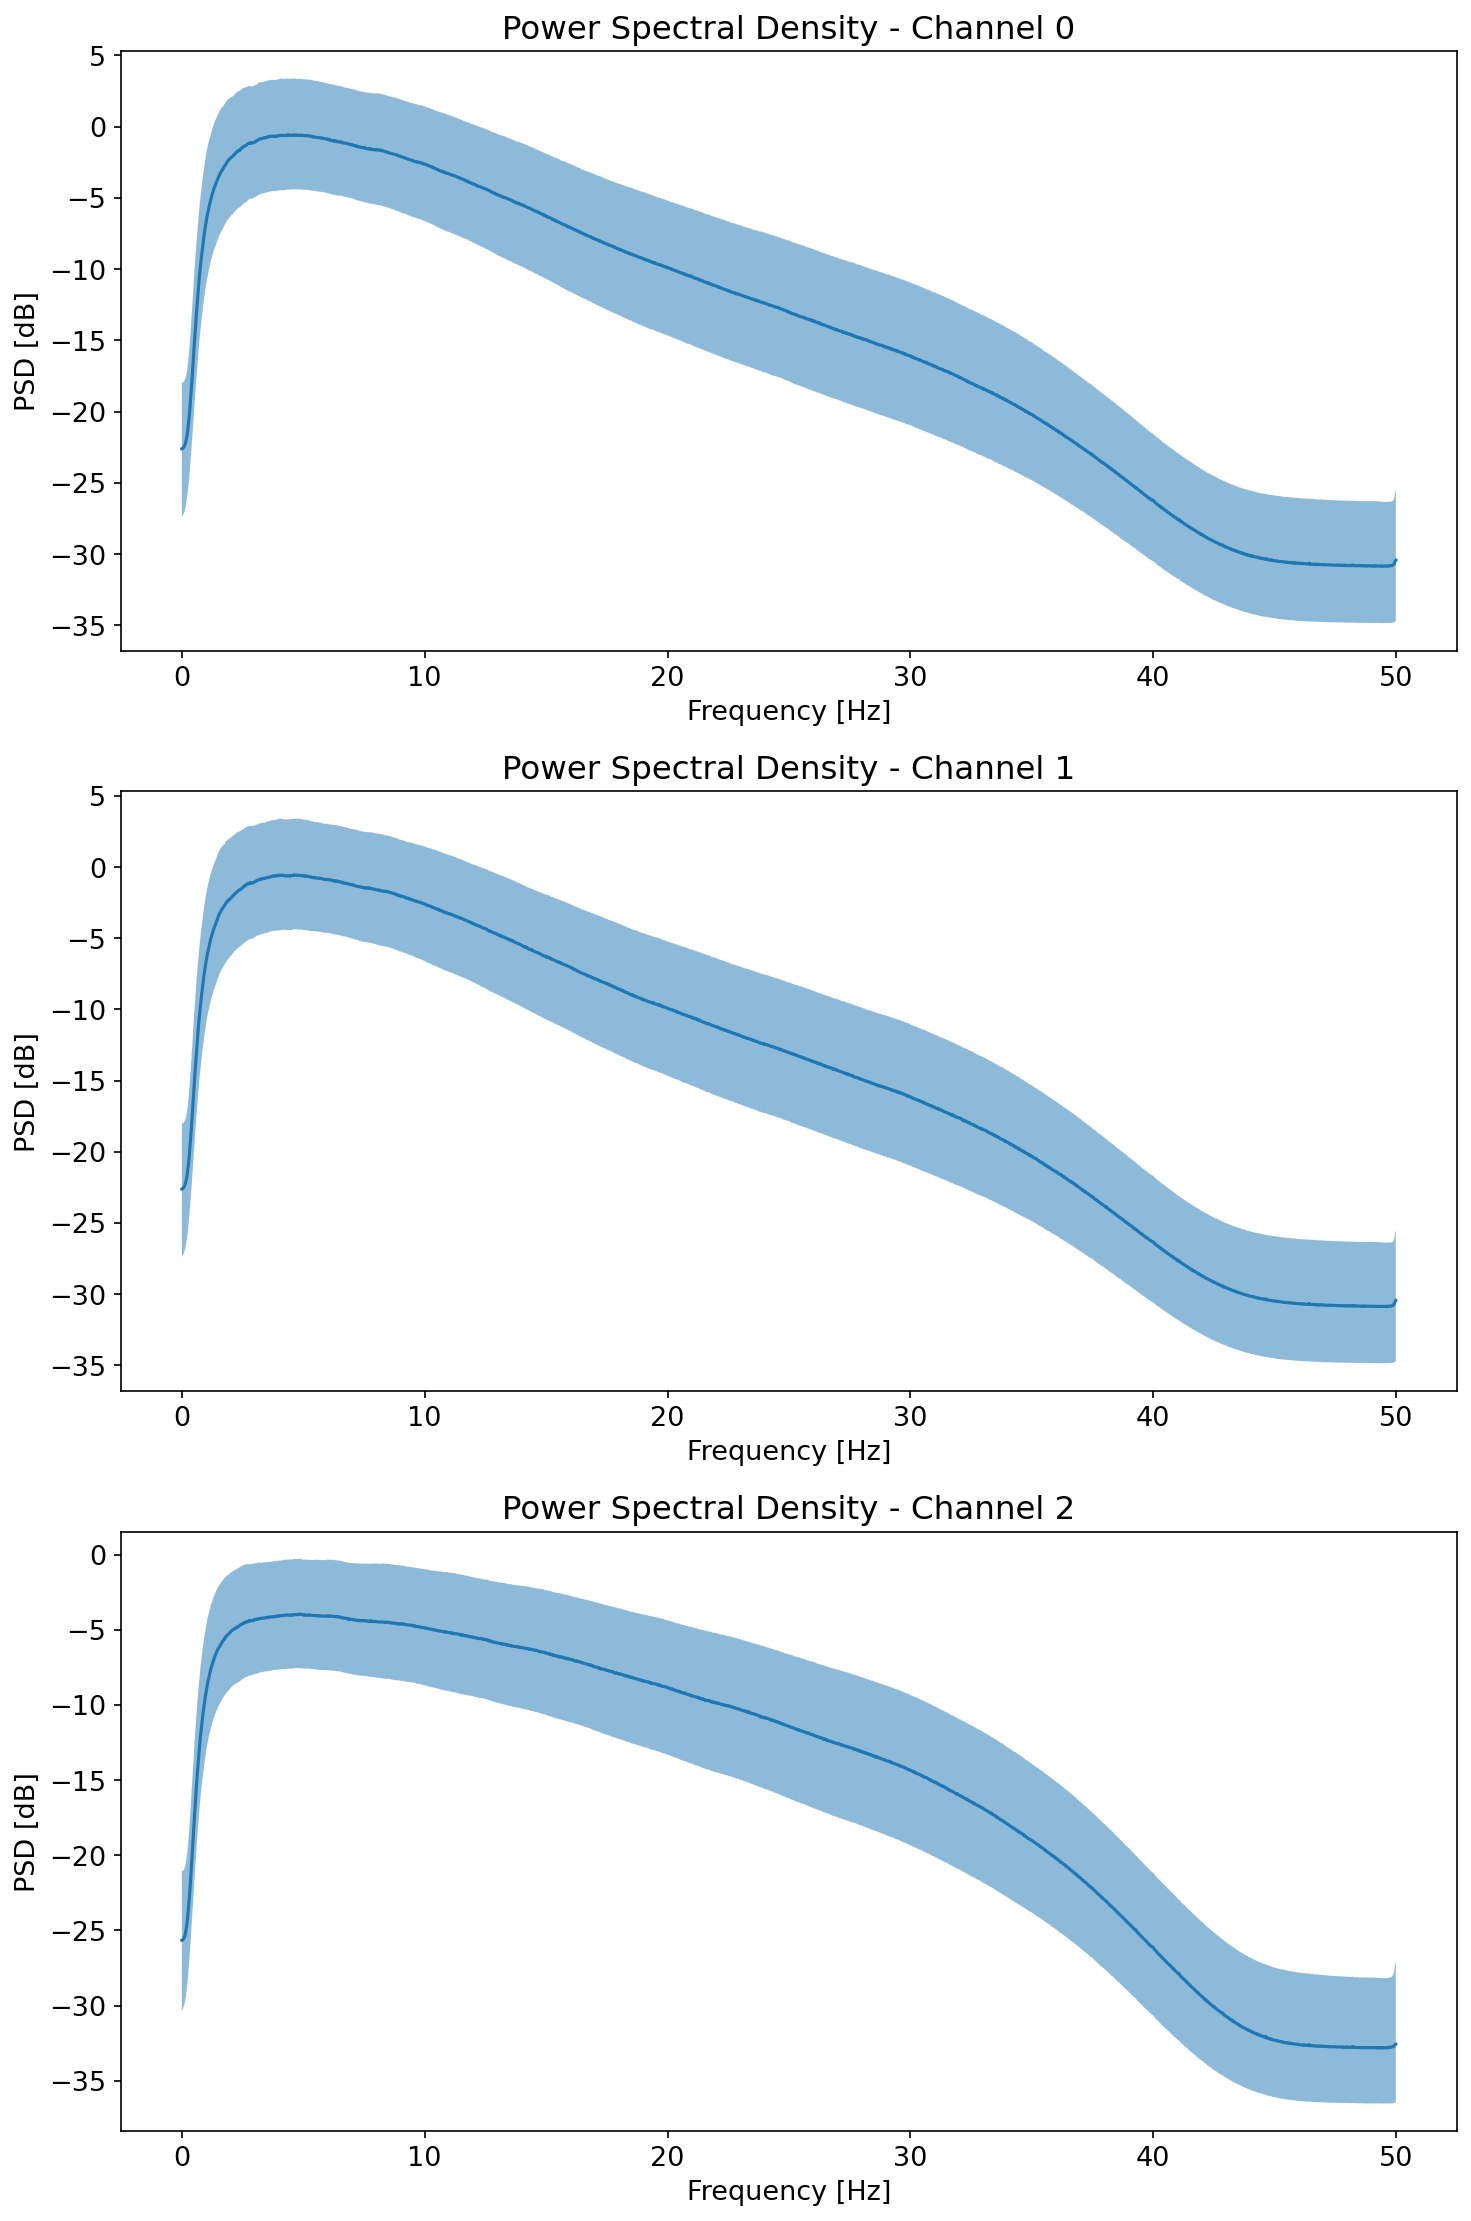

In [18]:
fig, axs = plt.subplots(config.num_channels, 1, figsize=(10, 5*config.num_channels))

psd = 10*np.log10(np.abs(np.fft.rfft(waveforms, axis=-1)) + 1e-7)
freq_axs = np.fft.rfftfreq(waveforms.shape[-1], d=1/config.fs)

print('done computing ffts')

psd_median = np.median(psd, axis=0)
psd_25 = np.percentile(psd, 25, axis=0)
psd_75 = np.percentile(psd, 75, axis=0)

for i in range(psd.shape[1]):
    axs[i].plot(freq_axs, psd_median[i], label=f"Median - N={waveforms.shape[0]}")
    axs[i].fill_between(freq_axs, psd_25[i], psd_75[i], alpha=0.5, label=f"IQR (25-75%) - N={waveforms.shape[0]}")
    axs[i].set_title(f"Power Spectral Density - Channel {i}")
    axs[i].set_xlabel("Frequency [Hz]")
    axs[i].set_ylabel("PSD [dB]")

plt.tight_layout()

## Bin Stats

Text(0.5, 1.0, 'Number of samples in each bin - Entire dataset')

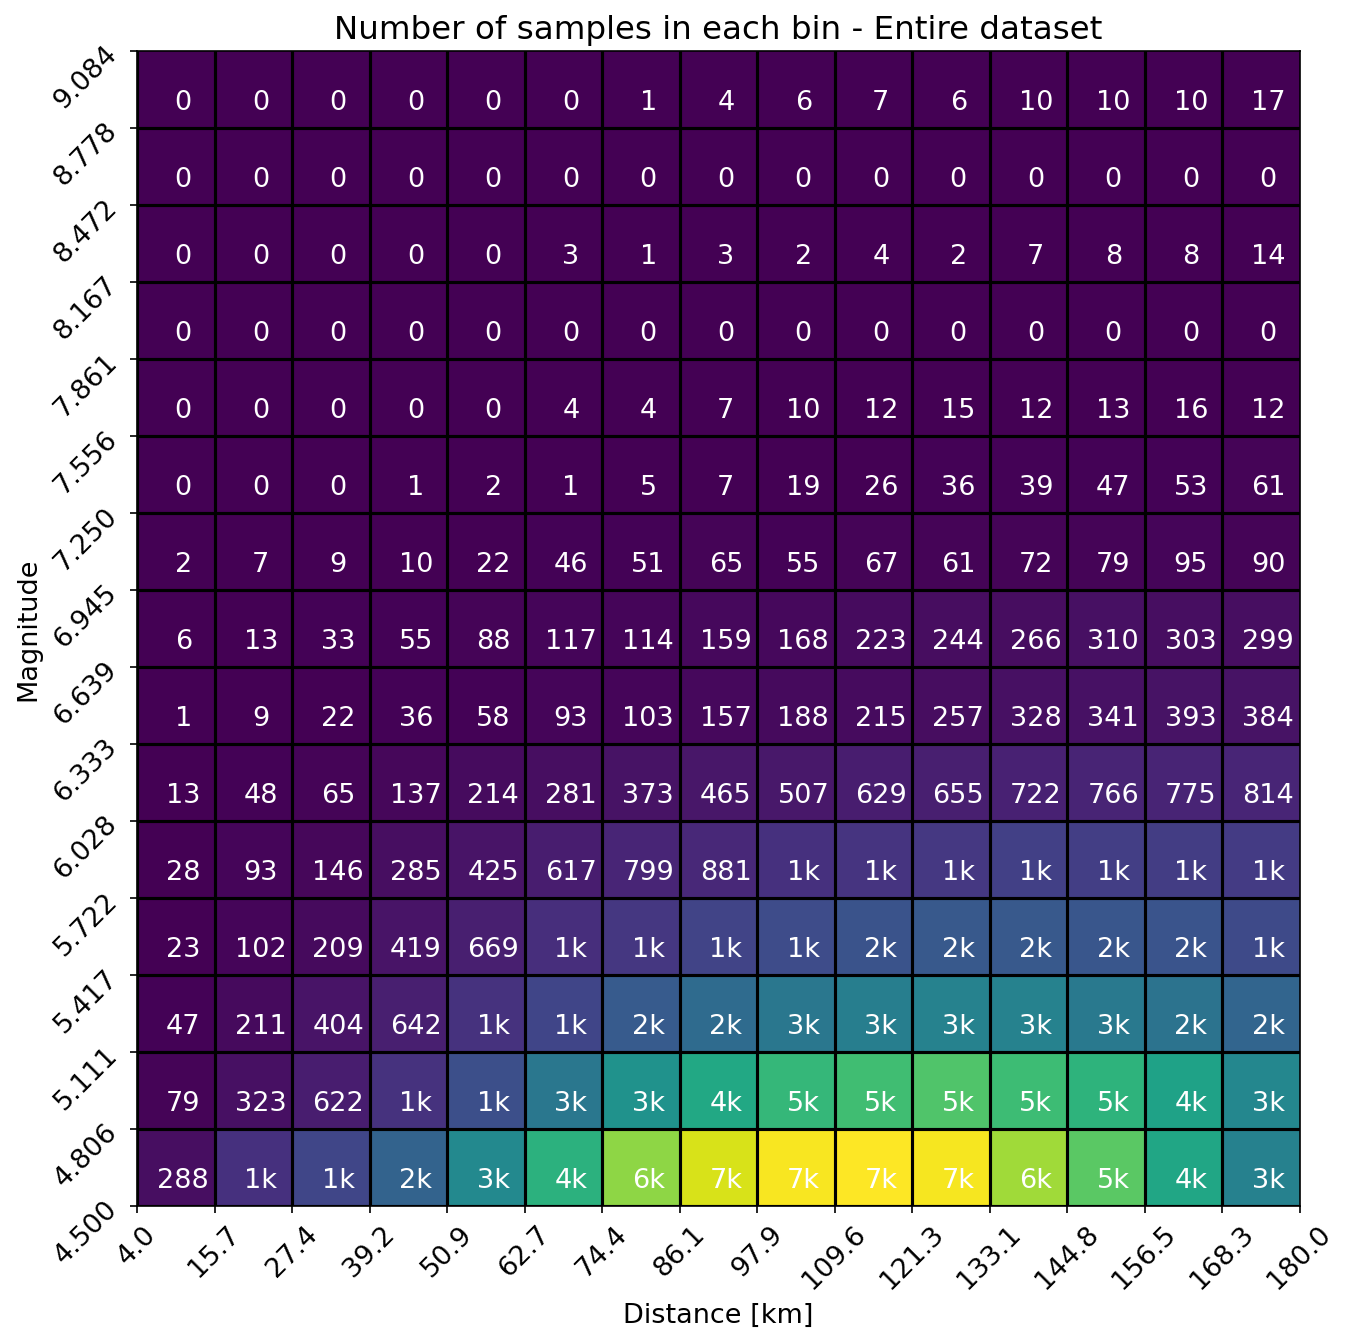

In [19]:
# 2d histogram
num_bins = 15
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.hist2d(features[:, 0], features[:, 2], bins=num_bins, cmap='viridis')

# set x and y ticks
ax.set_xticks(h[1])
ax.set_yticks(h[2])

# rotate the ticks
plt.xticks(rotation=45)
plt.yticks(rotation=45)

ax.set_xlabel("Distance [km]")
ax.set_ylabel("Magnitude")

for i in range(num_bins):
    ax.axvline(h[1][i], color='black')
    ax.axhline(h[2][i], color='black')

# annotate with number of samples
for i in range(num_bins):
    for j in range(num_bins):
        num_samples_bin = int(h[0][i, j]) if int(h[0][i, j]) < 1000 else f'{int(h[0][i, j])//1000}k'
        ax.text(h[1][i]+7, h[2][j]+.1, f'{num_samples_bin}', ha='center', va='center', color='white')

ax.set_title('Number of samples in each bin - Entire dataset')  

Text(0.5, 1.0, 'Number of samples in each bin - Entire dataset')

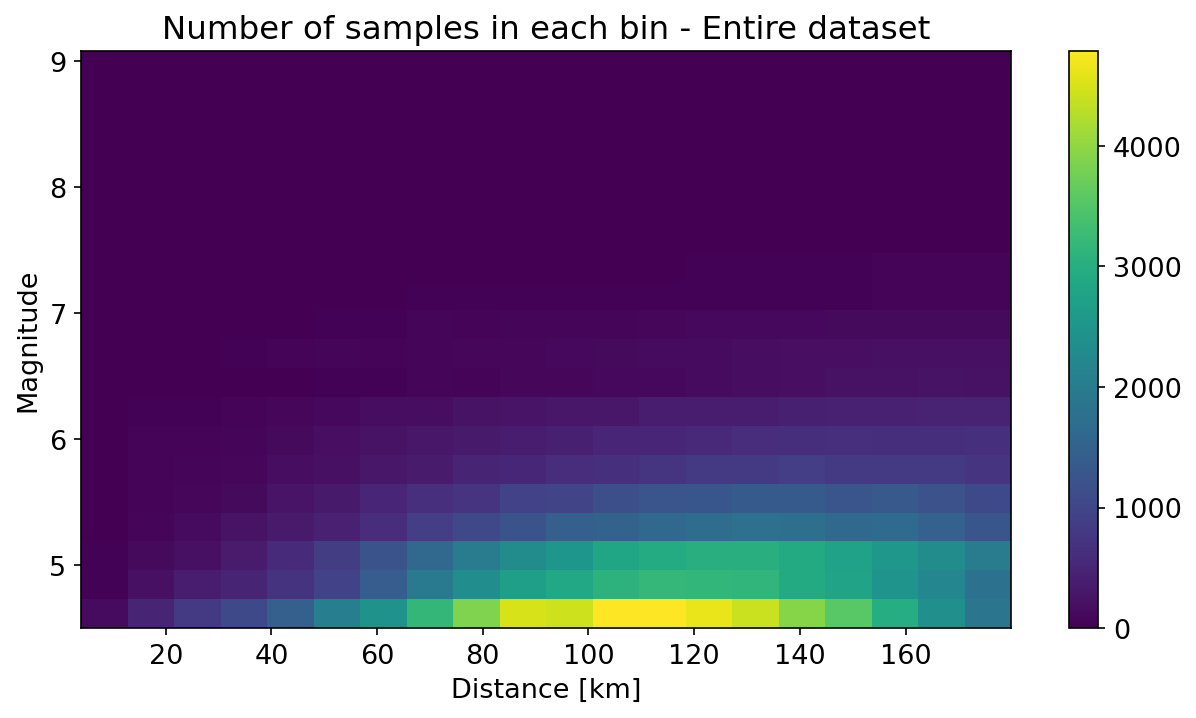

In [20]:
# plot number of samples in each bin of magnitude and distance
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
h = ax.hist2d(features[:, 0], features[:, 2], bins=20, cmap='viridis')

# add legend 
cbar = plt.colorbar(h[3], ax=ax)

ax.set_xlabel("Distance [km]")
ax.set_ylabel("Magnitude")

ax.set_title('Number of samples in each bin - Entire dataset') 

Text(0.5, 1.0, 'Number of samples in each bin - Train dataset')

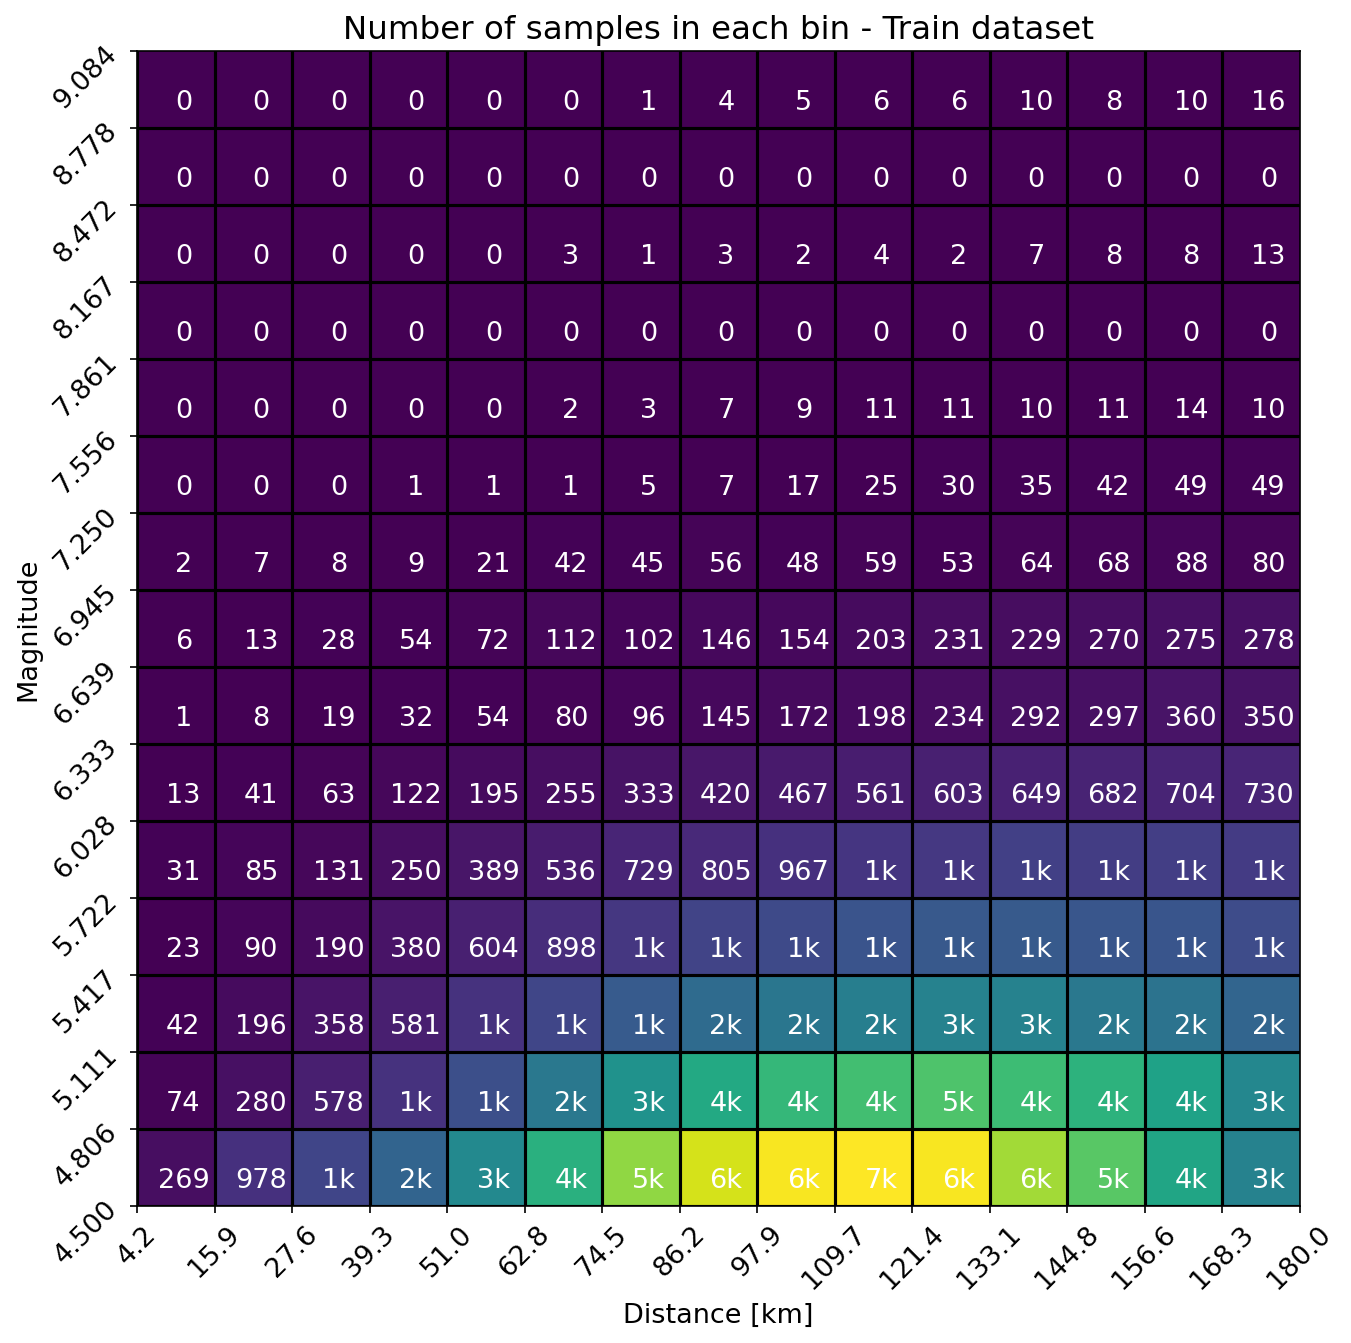

In [21]:
# 2d histogram
num_bins = 15
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.hist2d(train_dataset.features[:, 0], train_dataset.features[:, 2], bins=num_bins, cmap='viridis')

# set x and y ticks
ax.set_xticks(h[1])
ax.set_yticks(h[2])

# rotate the ticks
plt.xticks(rotation=45)
plt.yticks(rotation=45)

ax.set_xlabel("Distance [km]")
ax.set_ylabel("Magnitude")

for i in range(num_bins):
    ax.axvline(h[1][i], color='black')
    ax.axhline(h[2][i], color='black')

# annotate with number of samples
for i in range(num_bins):
    for j in range(num_bins):
        num_samples_bin = int(h[0][i, j]) if int(h[0][i, j]) < 1000 else f'{int(h[0][i, j])//1000}k'
        ax.text(h[1][i]+7, h[2][j]+.1, f'{num_samples_bin}', ha='center', va='center', color='white')

ax.set_title('Number of samples in each bin - Train dataset')   

Text(0.5, 1.0, 'Number of samples in each bin - Train dataset')

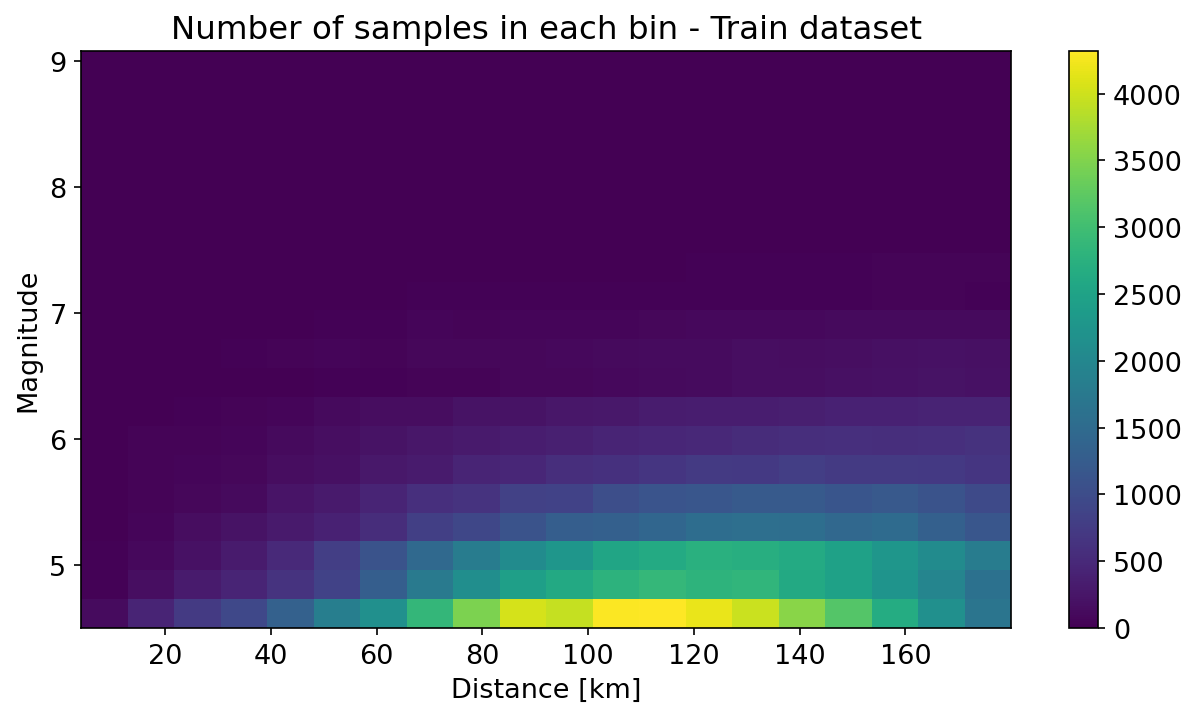

In [22]:
# plot number of samples in each bin of magnitude and distance
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
h = ax.hist2d(train_dataset.features[:, 0], train_dataset.features[:, 2], bins=(20, 20), cmap='viridis')

# add legend 
cbar = plt.colorbar(h[3], ax=ax)

ax.set_xlabel("Distance [km]")
ax.set_ylabel("Magnitude")

ax.set_title('Number of samples in each bin - Train dataset') 

Text(0.5, 1.0, 'Number of samples in each bin - Test dataset')

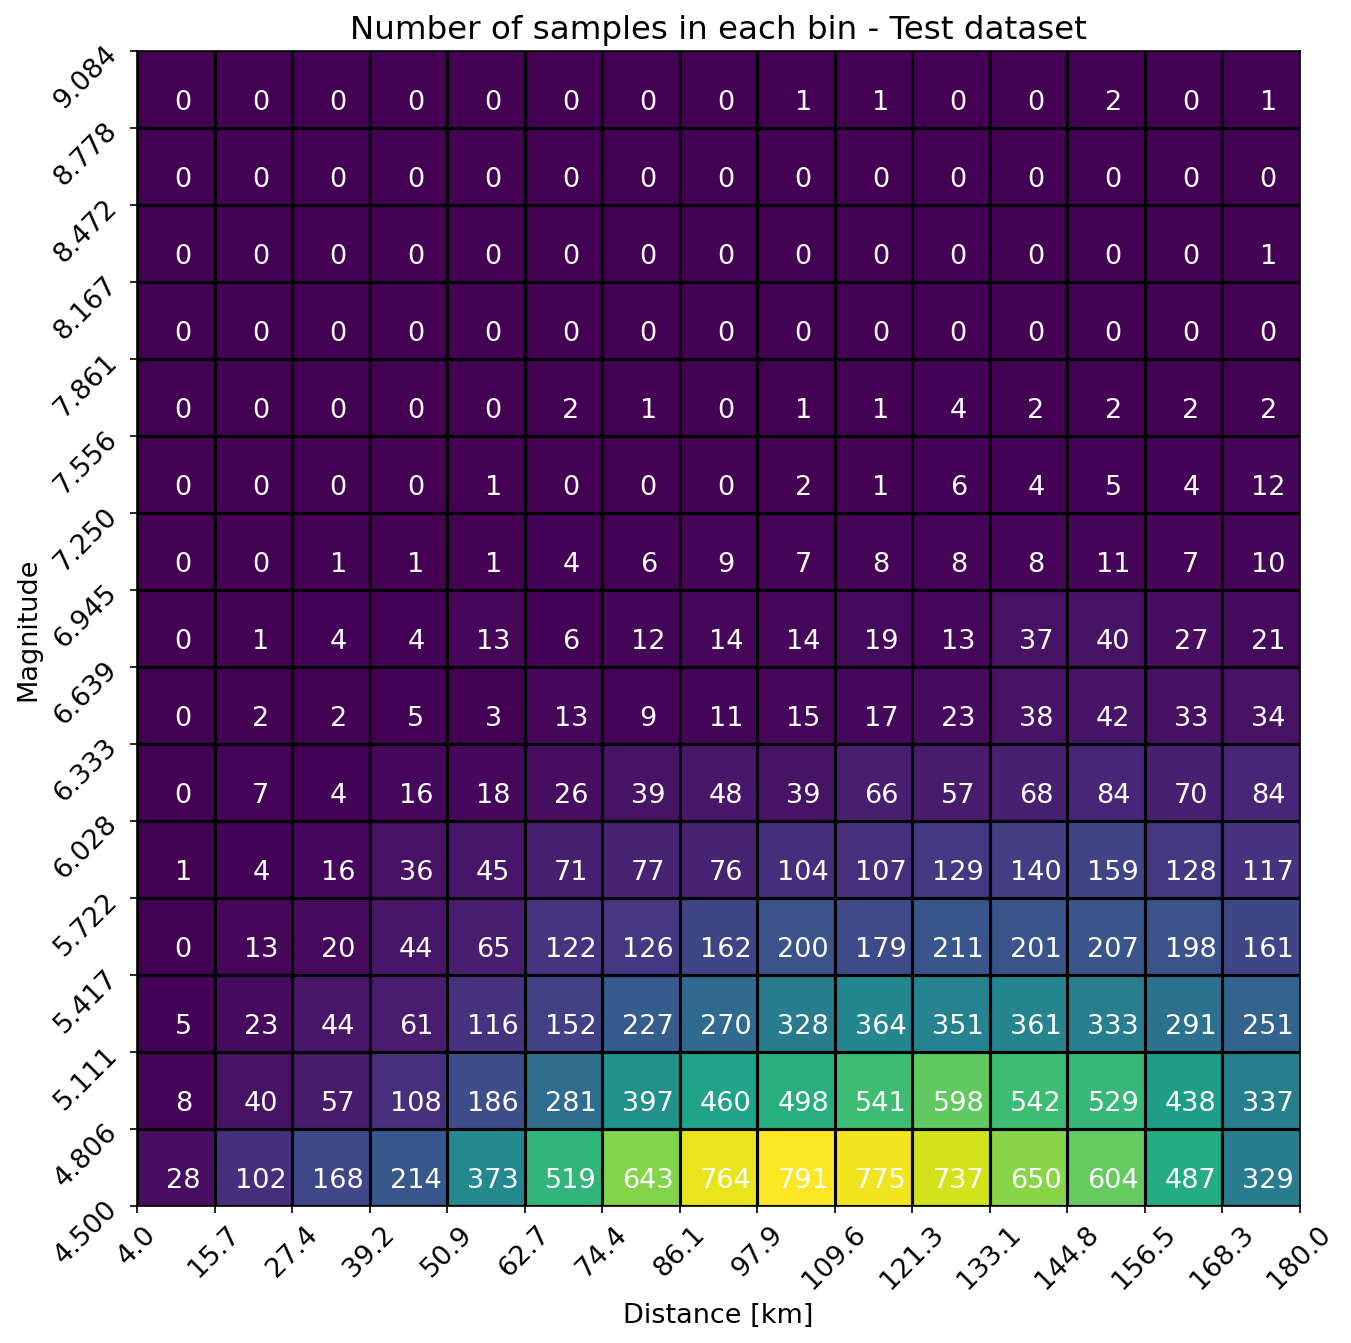

In [23]:
# 2d histogram
num_bins = 15
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.hist2d(test_dataset.features[:, 0], test_dataset.features[:, 2], bins=num_bins, cmap='viridis')

# set x and y ticks
ax.set_xticks(h[1])
ax.set_yticks(h[2])

# rotate the ticks
plt.xticks(rotation=45)
plt.yticks(rotation=45)

ax.set_xlabel("Distance [km]")
ax.set_ylabel("Magnitude")

for i in range(num_bins):
    ax.axvline(h[1][i], color='black')
    ax.axhline(h[2][i], color='black')

# annotate with number of samples
for i in range(num_bins):
    for j in range(num_bins):
        num_samples_bin = int(h[0][i, j]) if int(h[0][i, j]) < 1000 else f'{int(h[0][i, j])//1000}k'
        ax.text(h[1][i]+7, h[2][j]+.1, f'{num_samples_bin}', ha='center', va='center', color='white')

ax.set_title('Number of samples in each bin - Test dataset')  


Text(0.5, 1.0, 'Number of samples in each bin - Test dataset')

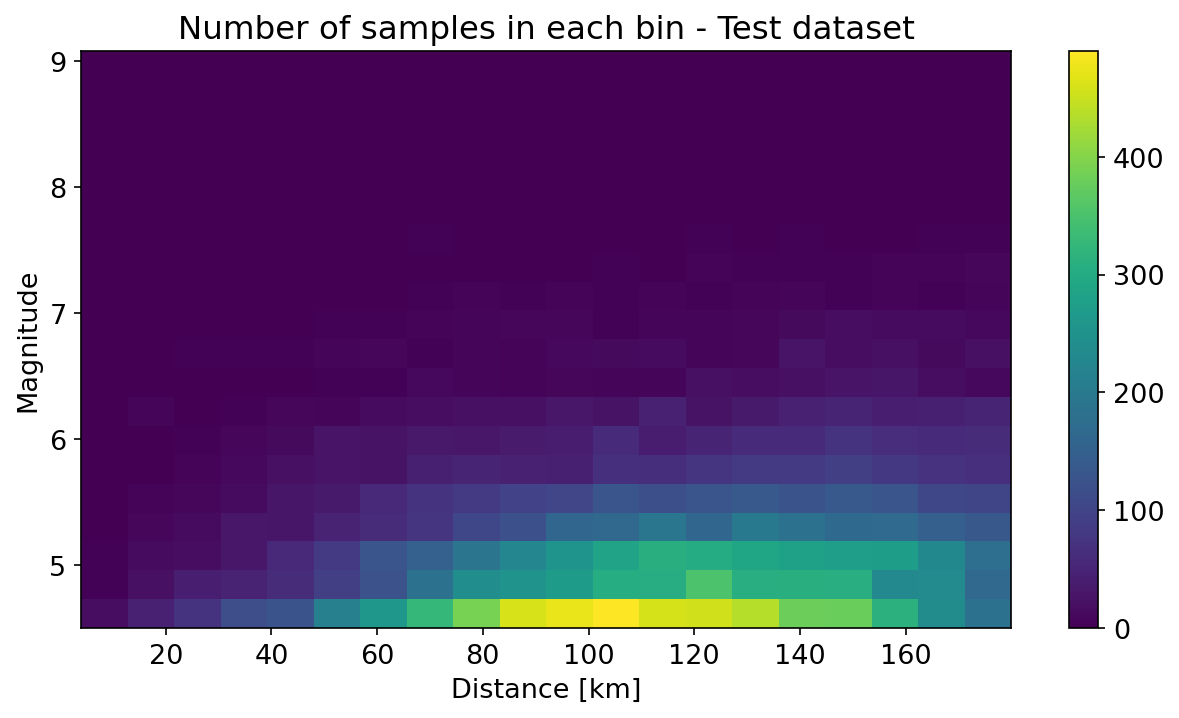

In [24]:
# plot number of samples in each bin of magnitude and distance
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
h = ax.hist2d(test_dataset.features[:, 0], test_dataset.features[:, 2], bins=(20, 20), cmap='viridis')

# add legend 
cbar = plt.colorbar(h[3], ax=ax)

ax.set_xlabel("Distance [km]")
ax.set_ylabel("Magnitude")

ax.set_title('Number of samples in each bin - Test dataset') 

In [25]:
mag_bins = [(4.5, 4.8), (4.8, 5), (5, 5.5), (5.5, 6.5), (6.5, 9.1)]
dist_bins = [(0, 50), (50, 100), (100, 150), (150, 200)]

Text(0.5, 1.0, 'Number of samples in each bin - Full dataset')

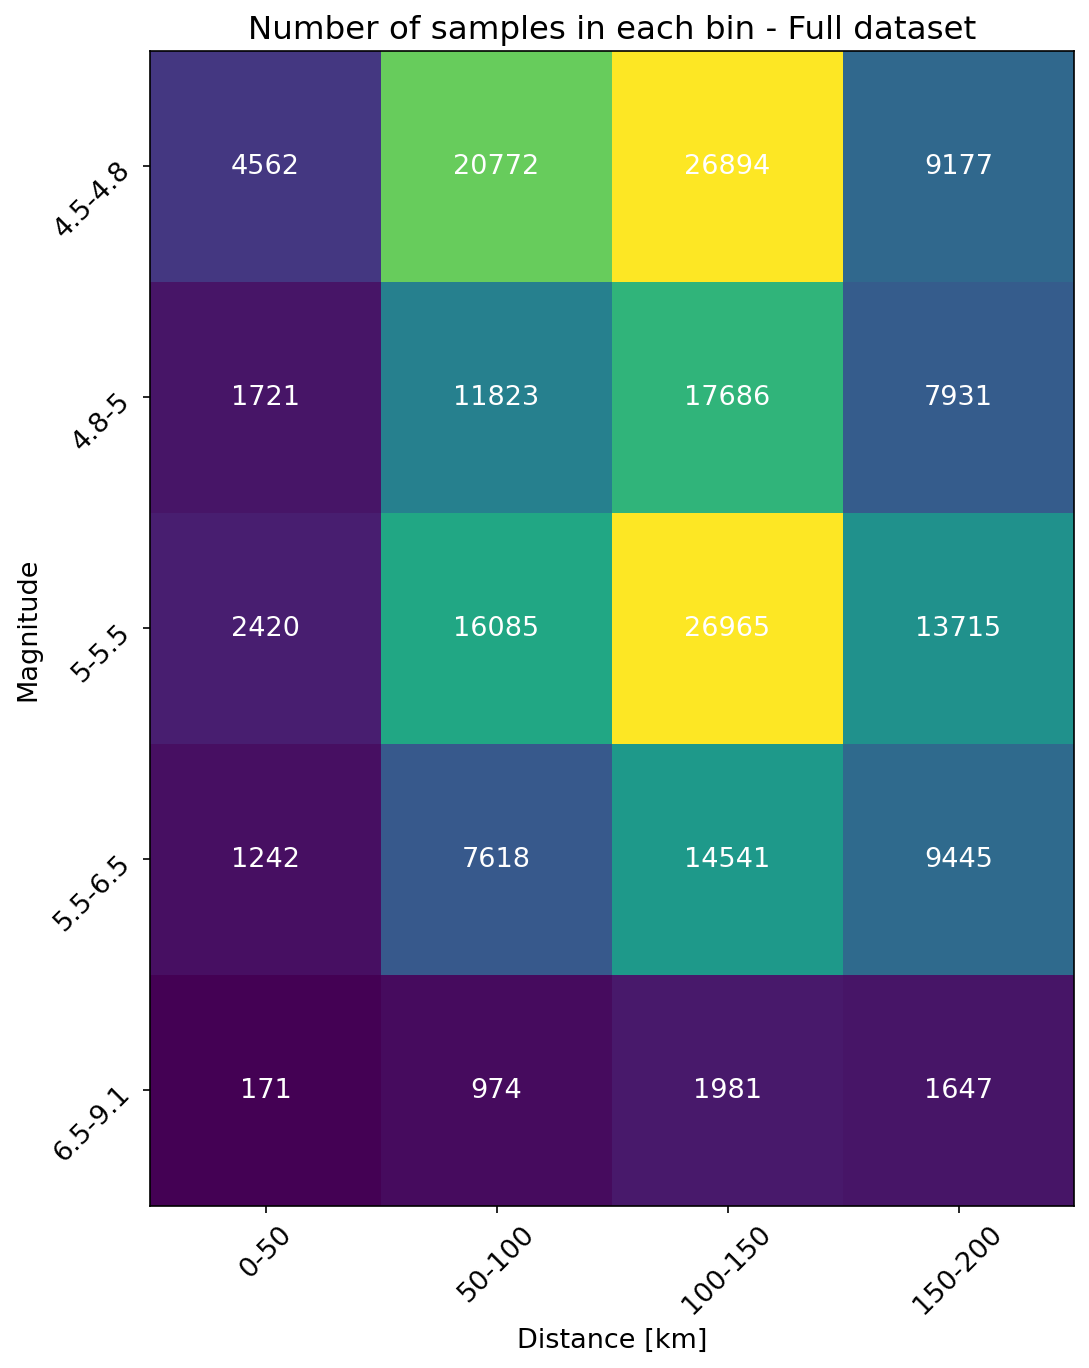

In [26]:
# find number of samples in each bin
n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - Full dataset')        

Check if the train and test distribution matches the one of the entire dataset

Text(0.5, 1.0, 'Number of samples in each bin - Train dataset')

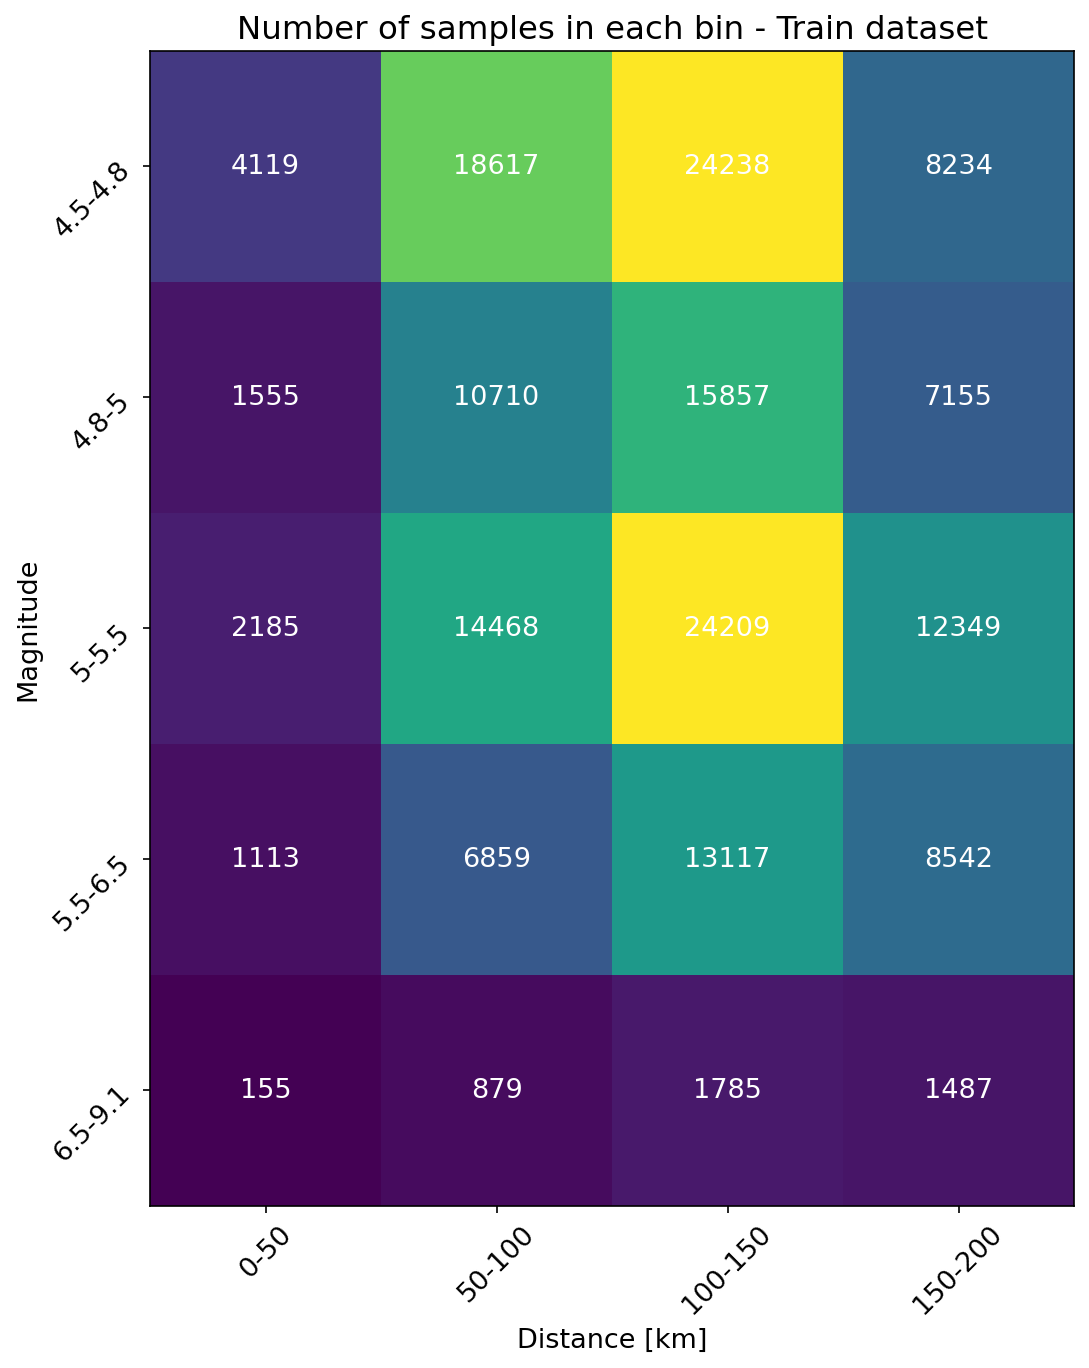

In [27]:
# find number of samples in each bin
features = train_dataset.features

n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - Train dataset')   

Text(0.5, 1.0, 'Number of samples in each bin - Test dataset')

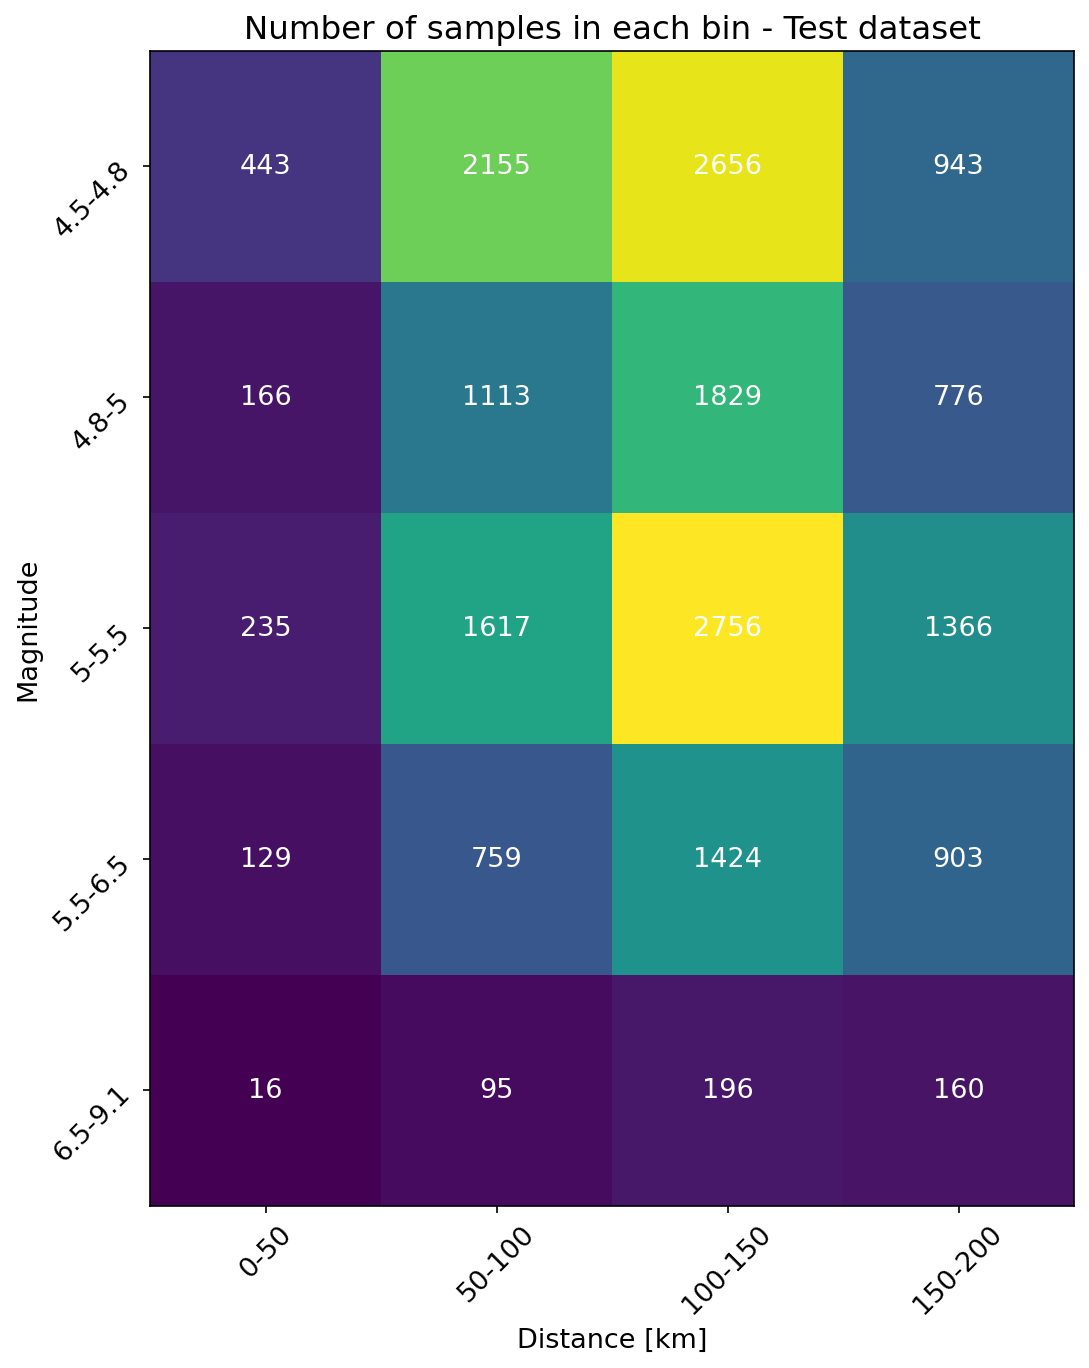

In [28]:
# find number of samples in each bin
features = test_dataset.features

n_samples = np.zeros((len(mag_bins), len(dist_bins)))
for i, (mag_min, mag_max) in enumerate(mag_bins):
    for j, (dist_min, dist_max) in enumerate(dist_bins):
        n_samples[i, j] = np.sum((features[:, 0] >= dist_min) & (features[:, 0] < dist_max) & (features[:, 2] >= mag_min) & (features[:, 2] < mag_max))

# plot number of samples in each bin, with annotations and with bin labels as ticks
fig, ax = plt.subplots(1, figsize=(10, 10))
h = ax.imshow(n_samples, cmap='viridis')
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Magnitude')
ax.set_xticks(np.arange(len(dist_bins)))
ax.set_xticklabels([f'{dist_min}-{dist_max}' for dist_min, dist_max in dist_bins], rotation=45)
ax.set_yticks(np.arange(len(mag_bins)))
ax.set_yticklabels([f'{mag_min}-{mag_max}' for mag_min, mag_max in mag_bins], rotation=45)
for i in range(len(mag_bins)):
    for j in range(len(dist_bins)):
        ax.text(j, i, f'{int(n_samples[i, j])}', ha='center', va='center', color='white')
ax.set_title('Number of samples in each bin - Test dataset')   

## Compute statistics of the training set

In [29]:
def compute_waveforms_statistics(waveforms, save_path):
    n = waveforms.shape[0]
    waveforms = np.nan_to_num(waveforms, nan=0)

    mean_signal = np.mean(waveforms, axis=0)
    std_dev_signal = np.std(waveforms, axis=0)
    max_signal = np.max(waveforms, axis=0)
    min_signal = np.min(waveforms, axis=0)

    mean = np.mean(waveforms, axis=(0,2))
    std = np.std(waveforms, axis=(0,2))
    max = np.max(waveforms, axis=(0,2))
    min = np.min(waveforms, axis=(0,2))

    num_channels = waveforms.shape[1]
    signal_statistics = {}
    for i in range(num_channels):
        signal_statistics[f'ch{i+1}'] = {'mean_signal': mean_signal[i], 'std_dev_signal': std_dev_signal[i], 'max_signal': max_signal[i], 'min_signal': min_signal[i], 'mean': mean[i], 'std_dev': std[i], 'max': max[i], 'min': min[i]}

    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(signal_statistics, f)
    
    print(f'Saved statistics to {save_path}')
    print(f'n: {n}, mean.shape: {mean.shape}, std.shape: {std.shape}, max.shape: {max.shape}, min.shape: {min.shape}, mean_signal.shape: {mean_signal.shape}, std_dev_signal.shape: {std_dev_signal.shape}, max_signal.shape: {max_signal.shape}, min_signal.shape: {min_signal.shape}')

In [30]:
from tqdne.dataset import RepresentationDataset
from tqdne.representations import SignalWithEnvelope
from torch.utils.data import DataLoader

In [36]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
train_dataset = RepresentationDataset(config.datasetdir / config.data_train, Signal(), pad=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/signal_statistics.pkl"))

100%|██████████| 1388/1388 [04:18<00:00,  5.38it/s]


Saved statistics to /users/abosisio/scratch/tqdne/outputs/signal_statistics.pkl
n: 177633, mean.shape: (3,), std.shape: (3,), max.shape: (3,), min.shape: (3,), mean_signal.shape: (3, 2750), std_dev_signal.shape: (3, 2750), max_signal.shape: (3, 2750), min_signal.shape: (3, 2750)


In [39]:
import pickle
with open('/users/abosisio/scratch/tqdne/outputs/signal_statistics.pkl', 'rb') as f:
    signal_statistics = pickle.load(f)
signal_statistics['ch1']['mean_signal'].shape, signal_statistics['ch1']['std_dev_signal'].shape, signal_statistics['ch1']['max_signal'].shape, signal_statistics['ch1']['min_signal'].shape, signal_statistics['ch1']['mean'], signal_statistics['ch1']['std_dev'], signal_statistics['ch1']['max'], signal_statistics['ch1']['min']

((2750,),
 (2750,),
 (2750,),
 (2750,),
 2.040648e-08,
 0.042397108,
 14.121915,
 -13.342398)

In [ ]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="moving_average",
    env_function_params=new_dict(
        scale=1
    ),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-5
    ),
    scaling=new_dict(
        type="none"
    ),
)

train_dataset = RepresentationDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), pad=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-5_mov-avg-1_ds-2.pkl"))

  0%|          | 0/1536 [00:00<?, ?it/s]100%|██████████| 1536/1536 [07:44<00:00,  3.30it/s]


Saved statistics to /users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-5_mov-avg-1_ds-2.pkl
n: 196608, mean.shape: (3,), std.shape: (3,), max.shape: (3,), min.shape: (3,), mean_signal.shape: (3, 2736), std_dev_signal.shape: (3, 2736), max_signal.shape: (3, 2736), min_signal.shape: (3, 2736)


In [ ]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="moving_average",
    env_function_params=new_dict(
        scale=3
    ),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-7
    ),
    scaling=new_dict(
        type="none"
    ),
)
train_dataset = RepresentationDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), pad=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-3_ds-2.pkl"))

100%|██████████| 1536/1536 [08:18<00:00,  3.08it/s]


Saved statistics to /users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-3.pkl
n: 196608, mean.shape: (3,), std.shape: (3,), max.shape: (3,), min.shape: (3,), mean_signal.shape: (3, 2736), std_dev_signal.shape: (3, 2736), max_signal.shape: (3, 2736), min_signal.shape: (3, 2736)


In [ ]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="moving_average",
    env_function_params=new_dict(
        scale=2
    ),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-7
    ),
    scaling=new_dict(
        type="none"
    ),
)
train_dataset = RepresentationDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), pad=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-2_ds-2.pkl"))

100%|██████████| 1426/1426 [07:04<00:00,  3.36it/s]


Saved statistics to /users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-2_ds-2.pkl
n: 182523, mean.shape: (3,), std.shape: (3,), max.shape: (3,), min.shape: (3,), mean_signal.shape: (3, 2751), std_dev_signal.shape: (3, 2751), max_signal.shape: (3, 2751), min_signal.shape: (3, 2751)


In [40]:
import pickle
with open('/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-7_mov-avg-2_ds-2.pkl', 'rb') as f:
    signal_statistics = pickle.load(f)
signal_statistics['ch1']['mean'], signal_statistics['ch1']['std_dev'], signal_statistics['ch1']['max'], signal_statistics['ch1']['min']

(-2.3184617, 0.95279765, 1.0369419, -7.0)

In [ ]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="first_order_lp",
    env_function_params=new_dict(),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-5
    ),
    scaling=new_dict(
        type="none"
    ),
)
train_dataset = RepresentationDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), pad=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-5_first-order-lp_ds-2.pkl"))

NameError: name 'EnvelopeDataset' is not defined

In [ ]:
import ml_collections 
def new_dict(**kwargs):
    return ml_collections.ConfigDict(initial_dictionary=kwargs)
              
params=new_dict(
    env_function="hilbert",
    env_function_params=new_dict(),
    env_transform="log",
    env_transform_params=new_dict(
        log_offset=1e-5
    ),
    scaling=new_dict(
        type="none"
    ),
)
train_dataset = RepresentationDataset(config.datasetdir / config.data_train, SignalWithEnvelope(**params), pad=config.signal_length, downsample=2)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
waveforms = []
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    waveforms.append(batch['repr'][:, :3, :].numpy(force=True))
waveforms = np.concatenate(waveforms, axis=0)
compute_waveforms_statistics(waveforms, save_path=Path("/users/abosisio/scratch/tqdne/outputs/log-env-stats_log-offset-1e-5_hilbert_ds-2.pkl"))

  0%|          | 0/1536 [00:00<?, ?it/s] 86%|████████▌ | 1318/1536 [05:52<00:56,  3.83it/s]

In [ ]:
n = waveforms.shape[-1]
waveforms = np.nan_to_num(waveforms, nan=0)

mean_signal = np.mean(waveforms, axis=2)
std_dev_signal = np.std(waveforms, axis=2)
max_signal = np.max(waveforms, axis=2)
min_signal = np.min(waveforms, axis=2)

mean = np.mean(waveforms, axis=(1,2))
std = np.std(waveforms, axis=(1,2))
max = np.max(waveforms, axis=(1,2))
min = np.min(waveforms, axis=(1,2))

n, mean_signal.shape, std_dev_signal.shape, max_signal.shape, min_signal.shape, mean.shape, std.shape, max.shape, min.shape

(196608, (3, 5501), (3, 5501), (3, 5501), (3, 5501), (3,), (3,), (3,), (3,))